# Modelos de Regresión y Clasificación
Dentro de este Jupyter Notebook, aplicamos diferentes modelos de regresion y clasificacion para intentar realizar predicciones sobre el dataset de Olist y evaluar su rendimiento. Entre las variables y los modelos incluimos

- Modelos de Regresion
    - Prediccion de Review Score, a pesar de ser mas un problema de clasificacion decidimos incluirlo dentro de regresiones para tener un analisis comparativo
    - Prediccion de Delivery Days

- Modelos de Clasificacion
    - Prediccion de Review Score
    - Prediccion de Delivery Delayed, para pedidos atrasados
    - Prediccion de Satisfaccion del Cliente, 4+ en Review Score = Satisfecho. No satisfecho de lo contrario

Antes de empezar a trabajar con los modelos, vamos a separar todos nuestros splits de train / test. Esto lo haremos separando un DF por cada una de nuestras variable objetivo, para prevenir scaling poco adecuado o data leakage a traves de variables como 'delivery delayed' para 'delivery time'.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Primero, separamos en predicciones de review_score, delivery_days y delivery_delayed
dfreview = pd.read_csv('dataset/cleaned_orders.csv')
dfreview = dfreview.dropna()

dfdays = pd.read_csv('dataset/cleaned_orders.csv')
dfdays = dfdays.dropna()

dfdelayed = pd.read_csv('dataset/cleaned_orders.csv')
dfdelayed = dfdelayed.dropna()

# Dropeamos columnas que pueden causar data leakage
dfdays.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dfdelayed.drop(columns=['delivery_days', 'delivery_delta', 'review_score'], inplace=True)

# Separar en test y train con 30/70 para predicciones de satisfaccion
review_train, review_test = train_test_split(
    dfreview,
    test_size=0.3,
    stratify=dfreview['review_score'],
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery_days
days_train, days_test = train_test_split(
    dfdays,
    test_size=0.3,
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery_delayed
delayed_train, delayed_test = train_test_split(
    dfdelayed,
    test_size=0.3,
    random_state=42
)

Y_review_train = review_train['review_score']
X_review_train = review_train.drop(columns=['review_score'])

Y_review_test = review_test['review_score']
X_review_test = review_test.drop(columns=['review_score'])

Y_days_train = days_train['delivery_days']
X_days_train = days_train.drop(columns=['delivery_days'])

Y_days_test = days_test['delivery_days']
X_days_test = days_test.drop(columns=['delivery_days'])

Y_delayed_train = delayed_train['delivery_delayed']
X_delayed_train = delayed_train.drop(columns=['delivery_delayed'])

Y_delayed_test = delayed_test['delivery_delayed']
X_delayed_test = delayed_test.drop(columns=['delivery_delayed'])

# Escalamos las columnas correspondientes y separamos en train / test para cada modelo
cols_review = [
    'freight_value',
    'price',
    'product_weight_g',
    'product_volume_cm3',
    'estimated_delivery_days',
    'delivery_days',
    'delivery_delta',
    'shipping_distance_km',
    'payment_installments',
    'product_description_lenght',
    'product_photos_qty',
]

scaler_review = StandardScaler()

X_review_train[cols_review] = scaler_review.fit_transform(X_review_train[cols_review])
X_review_test[cols_review] = scaler_review.transform(X_review_test[cols_review])

cols_days = [
    'freight_value',
    'price',
    'product_weight_g',
    'product_volume_cm3',
    'shipping_distance_km',
    'payment_installments',
    'product_description_lenght',
    'product_photos_qty',
]

scaler_days = StandardScaler()

X_days_train[cols_days] = scaler_days.fit_transform(X_days_train[cols_days])
X_days_test[cols_days] = scaler_days.transform(X_days_test[cols_days])

cols_delayed = [
    'freight_value',
    'price',
    'product_weight_g',
    'product_volume_cm3',
    'estimated_delivery_days',
    'shipping_distance_km',
    'payment_installments',
    'product_description_lenght',
    'product_photos_qty',
]

Y_satisfaction_train = (Y_review_train >= 4).astype(int)
Y_satisfaction_test = (Y_review_test >= 4).astype(int)
X_satisfaction_train = X_review_train.copy()
X_satisfaction_test = X_review_test.copy()

scaler_delayed = StandardScaler()
X_delayed_train[cols_delayed] = scaler_delayed.fit_transform(X_delayed_train[cols_delayed])
X_delayed_test[cols_delayed] = scaler_delayed.transform(X_delayed_test[cols_delayed])

KeyError: "['estimated_delivery_days'] not in index"

Luego, vamos a crear una funcion de utilidad para graficar los resultados de nuestras regresiones.

In [44]:
def plot_regression_results(Y_test, Y_pred, target_column_name="Target", model_name="Model"):
    residuals = Y_test - Y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(Y_test, Y_pred,
                    alpha=0.025,
                    s=10)
    min_val = min(Y_test.min(), Y_pred.min())
    max_val = max(Y_test.max(), Y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel(f"Valores Reales ({target_column_name})", fontsize=12)
    axes[0].set_ylabel(f"Predicciones ({target_column_name})", fontsize=12)
    axes[0].set_title(f"Valores Reales vs Predicciones\n({model_name})", fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(Y_pred, residuals,
                    alpha=0.025,
                    s=10)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel(f"Valores Predichos ({target_column_name})", fontsize=12)
    axes[1].set_ylabel("Residuos", fontsize=12)
    axes[1].set_title(f"Residuos vs. Predichos\n({model_name})", fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def print_regression_metrics(Y_test, Y_pred, model_name="Model"):
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mse)

    print(f"\n--- Evaluación de {model_name} ---")
    print(f"Mean Squared Error (MSE):     {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE):    {mae:.6f}")
    print(f"R-squared (R²):               {r2:.6f}")
    print("-" * (len(f"--- Evaluación del {model_name} ---")))

Y por ultimo, otras funciones de utilidad para graficar resultados de los modelos de clasificacion

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc # Added confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def print_classification_metrics(Y_test, Y_pred, model_name="Model", average='weighted'):
    print(f"\n--- Metrics for {model_name} ---")
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("Precision:", precision_score(Y_test, Y_pred, average=average, zero_division=0))
    print("Recall:", recall_score(Y_test, Y_pred, average=average, zero_division=0))
    print("F1-Score:", f1_score(Y_test, Y_pred, average=average, zero_division=0))
    print("\nClassification Report:")
    print(classification_report(Y_test, Y_pred, zero_division=0))
    print("-" * (len(model_name) + 20)) # Separator line


def plot_confusion_matrix(Y_test, Y_pred, model_name="Model", classes=None):
    cm = confusion_matrix(Y_test, Y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes if classes else ['0', '1'],
                yticklabels=classes if classes else ['0', '1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def plot_cap_curve(Y_test, Y_pred_proba, model_name="Model"):
    y_true = Y_test
    y_prob = Y_pred_proba[:, 1]

    df_cap = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df_cap = df_cap.sort_values(by='y_prob', ascending=False)

    n_total = len(y_true)
    n_positive = df_cap['y_true'].sum()

    cumulative_count = np.arange(1, n_total + 1)
    cumulative_positive = df_cap['y_true'].cumsum()

    cap_curve = cumulative_positive / n_positive
    random_curve = cumulative_count / n_total
    perfect_curve = np.minimum(cumulative_count, n_positive) / n_positive

    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_count, cap_curve, label=model_name, color='blue')
    plt.plot(cumulative_count, random_curve, label='Random Model', color='gray', linestyle='--')
    plt.plot(cumulative_count, perfect_curve, label='Perfect Model', color='red', linestyle='--')

    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Proportion of Positive Class')
    plt.title(f'Cumulative Accuracy Profile (CAP) Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Modelos de Regresion
En esta seccion implementamos los modelos de de regresion Random Forest, KNN y SVR. Para cada uno de estos modelos implementamos predicciones de

- Delivery Days, los dias que se tarda en llegar un pedido
- Review Score, el puntaje de 1-5 dejado en los reviews de un pedido

Es importante tomar en cuenta que el problema de Review Score podría ser resuelto de una manera más adecuada por un modelo de clasificación. Sin embargo, decidimos aplicar modelos de regresión con la finalidad de comparar los modelos y realizar un análisis de regresión vs clasificación para predicciones con valores discretos.

Para cada una de las predicciones implementamos un modelo baseline, luego un modelo con diferentes parametros y por ultimo un modelo con Validacion Cruzada.

## Random Forest

### Delivery Days

**Modelo Baseline**

In [46]:
# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento de modelo
rf_regressor.fit(X_days_train, Y_days_train)

# Predicciones con el modelo
Y_pred = rf_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    target_column_name='Delivery Days',
    model_name='Random Forest (max_depth 4)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    model_name='Random Forest (max_depth 4)'
)

KeyboardInterrupt: 

El modelo tiene un R2 de 0.29, esto indica un desempeño algo pobre. Sin embargo, observando la gráfica de valores predichos en comparación a los reales parece que el modelo logra captar el trend inicial. Los puntos de predicciones se centran en cercanía a la línea de predicciones, pero el modelo falla completamente en predecir valores mayores a 17 días de envío. Esto puede deberse a algunos parámetros del modelo, dónde un depth tan bajo puede excluir completamente los valores con menor representación y los agrupa con los demás. Adicionalmente, en la gráfica de residuos podemos observar que el modelo parece no haber captado relaciones entre las variables.

**Modelo con Nuevos Parametros**

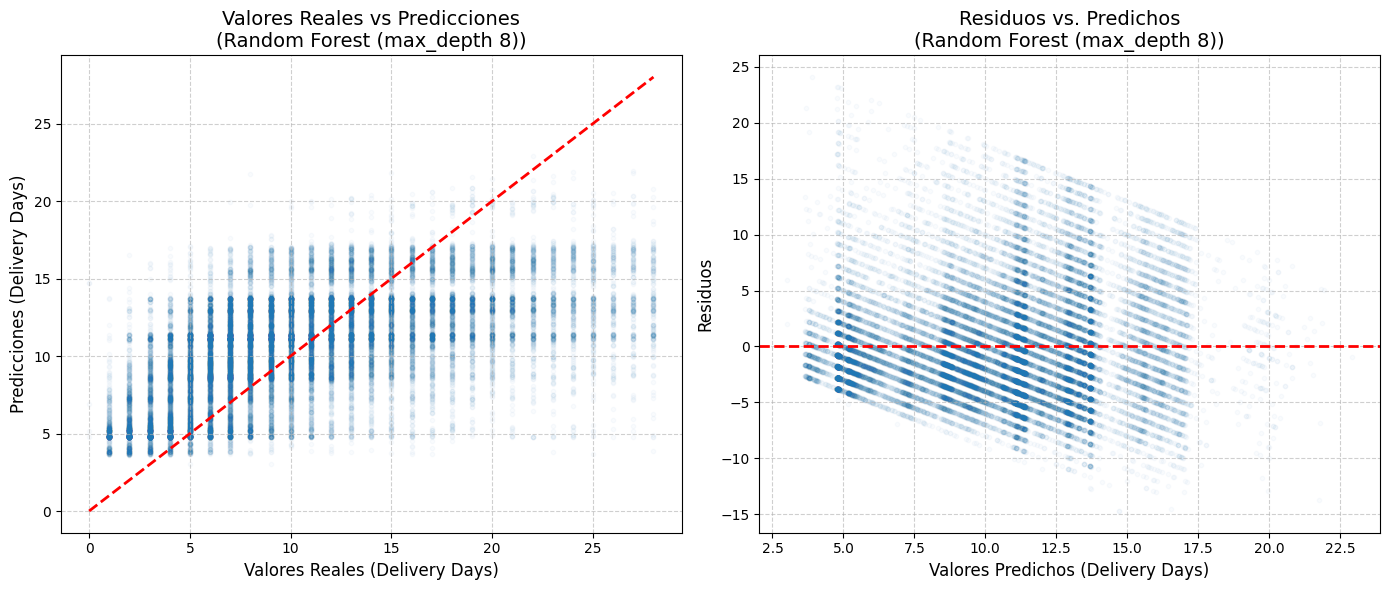


--- Evaluación de Random Forest (max_depth 8) ---
Mean Squared Error (MSE):     24.566110
Root Mean Squared Error (RMSE): 4.956421
Mean Absolute Error (MAE):    3.835460
R-squared (R²):               0.325064
--------------------------------------------------


In [ ]:
# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 8)

# Entrenamiento de modelo
rf_regressor.fit(X_days_train, Y_days_train)

# Predicciones con el modelo
Y_pred = rf_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    target_column_name='Delivery Days',
    model_name='Random Forest (max_depth 8)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred,
    model_name='Random Forest (max_depth 8)'
)

Este modelo mejoro marginalmente el R2, obteniendo un resultado de 0.315. Además, en la gráfica de valores predichos vs actuales parece empezar a tener predicciones más precisas para los valores más altos en comparación al anterior. Luego, la gráfica de residuos parece tener una disribución un poco más uniforme en comparación al modelo anterior. Esto nos indica una mejora, sin embargo podemos seguir lejos de los parámetros óptimos.

**Modelo Gridsearch con CV**

Descripcion del modelo


--- Evaluación de RF (CV) ---
Mean Squared Error (MSE):     21.207188
Root Mean Squared Error (RMSE): 4.605126
Mean Absolute Error (MAE):    3.434343
R-squared (R²):               0.417348
------------------------------


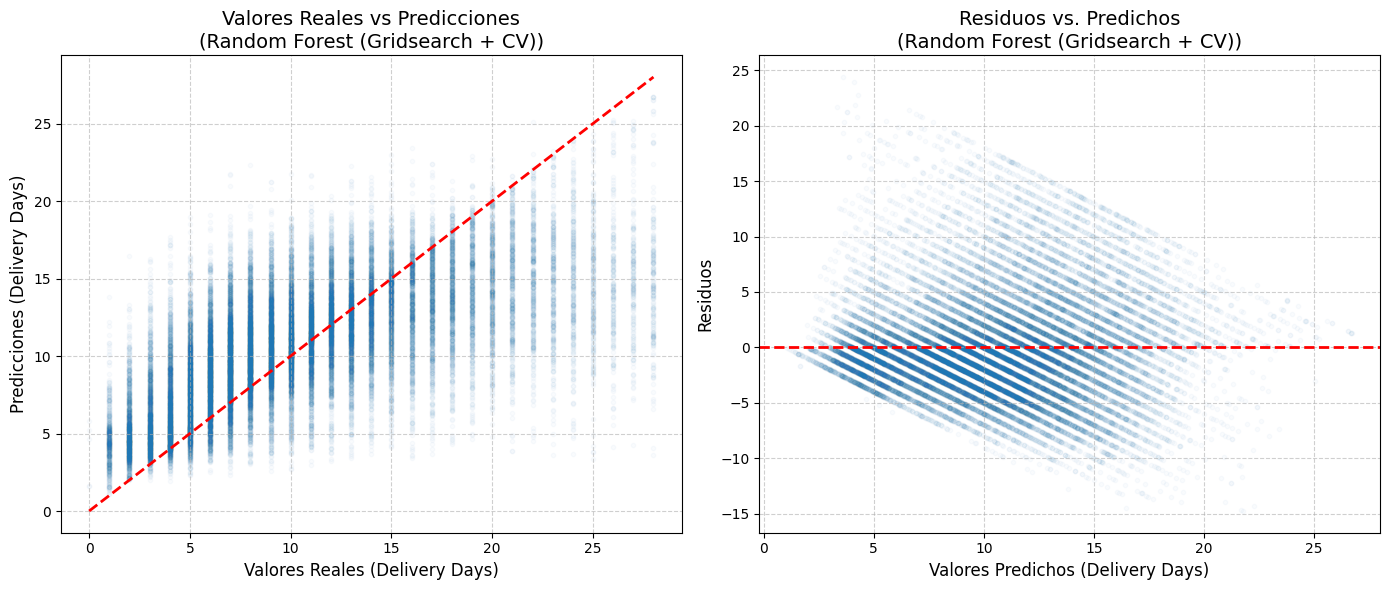

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time

param_grid_less_extensive = {
    'n_estimators': [100, 200],
    'max_depth': [15, 25, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_regressor_cv = RandomForestRegressor(random_state=42)

grid_search_cv = GridSearchCV(
    estimator=rf_regressor_cv,
    param_grid=param_grid_less_extensive,
    cv=5,
    scoring='r2',
    n_jobs=-1,
)

grid_search_cv.fit(X_days_train, Y_days_train)

best_rf_cv = grid_search_cv.best_estimator_

Y_pred_cv = best_rf_cv.predict(X_days_test)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv,
    model_name='RF (CV)'
)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv,
    target_column_name='Delivery Days',
    model_name='Random Forest (Gridsearch + CV)'
)

Este modelo tiene un R2 de 0.335, dandonos una mejora sobre el anterior. Sin embargo, seguimos teniendo algunos de los mismos problemas. Para los valores mas altos, este modelo parece incapaz de aprender sobre como clasificarlos correctamente. Esto se puede deber a la menor cantidad de modelos de este tipo, o falta de características distintivas.

**Análisis Comparativo**

El modelo con validación cruzada probó tener un rendimiento superior, sin embargo no fue una distinción tan clara. Esto se puede deber a limitaciones dentro de los datos (dónde por ejemplo, existen muy pocos datos sobre casos con días de entrega muy altos) o una exploración limitada sobre los parámetros del modelo. En general, podemos concluir que la variación de parámetros tuvo un rendimiento significativamente superior a los parámetros iniciales y la lo mismo se puede decir sobre la validación cruzada.

## KNN

### Delivery Days

**Modelo 'Baseline'**

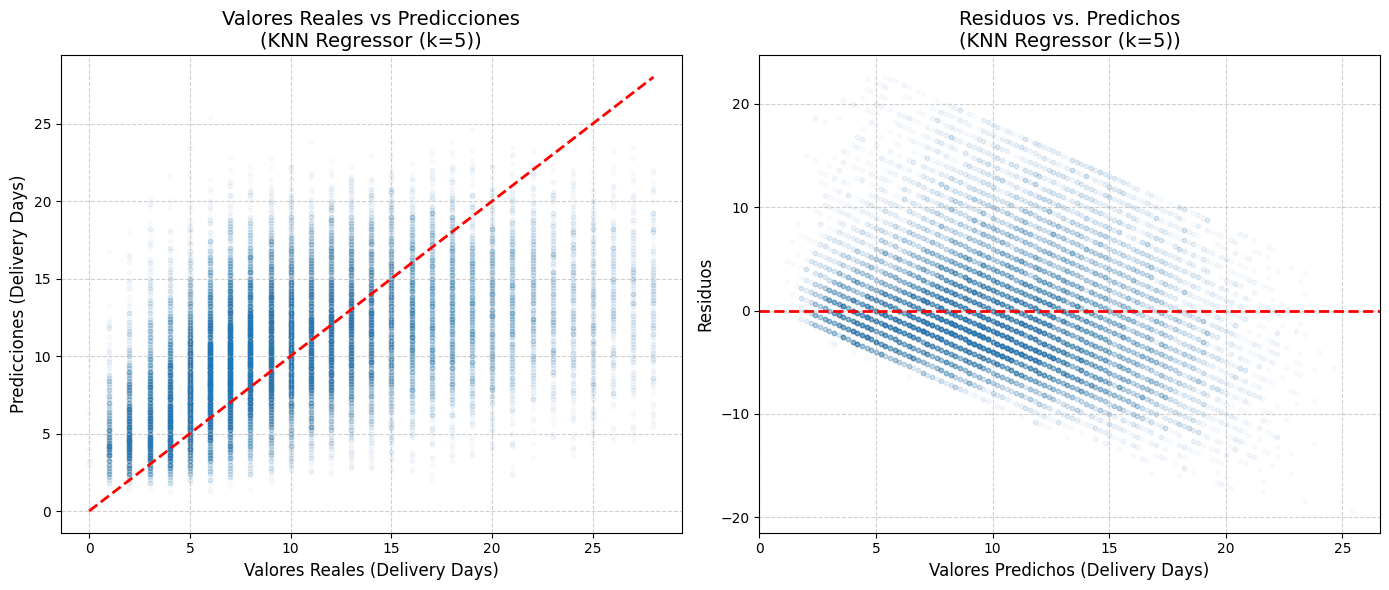


--- Evaluación de KNN Regressor (k=5) ---
Mean Squared Error (MSE):     29.122045
Root Mean Squared Error (RMSE): 5.396484
Mean Absolute Error (MAE):    4.144471
R-squared (R²):               0.202743
------------------------------------------


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

knn_regressor = KNeighborsRegressor(n_neighbors=5)

knn_regressor.fit(X_days_train, Y_days_train)
Y_pred_knn = knn_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (k=5)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    model_name='KNN Regressor (k=5)'
)

Este modelo inicial tiene indicadores prometedores, parece captar el trend inicial entre 0-15 días al tener una concentración cercana a la línea perfecta. Sin embargo, continúa con algunos de los dolores de los modelos anteriores. Para deliveries más largos, le es difícil realizar predicciones y según la gráfica de residuales parece tener una dificultad más grande para predecir mientras su valor aumenta.

**Modelo con Nuevos Parametros**

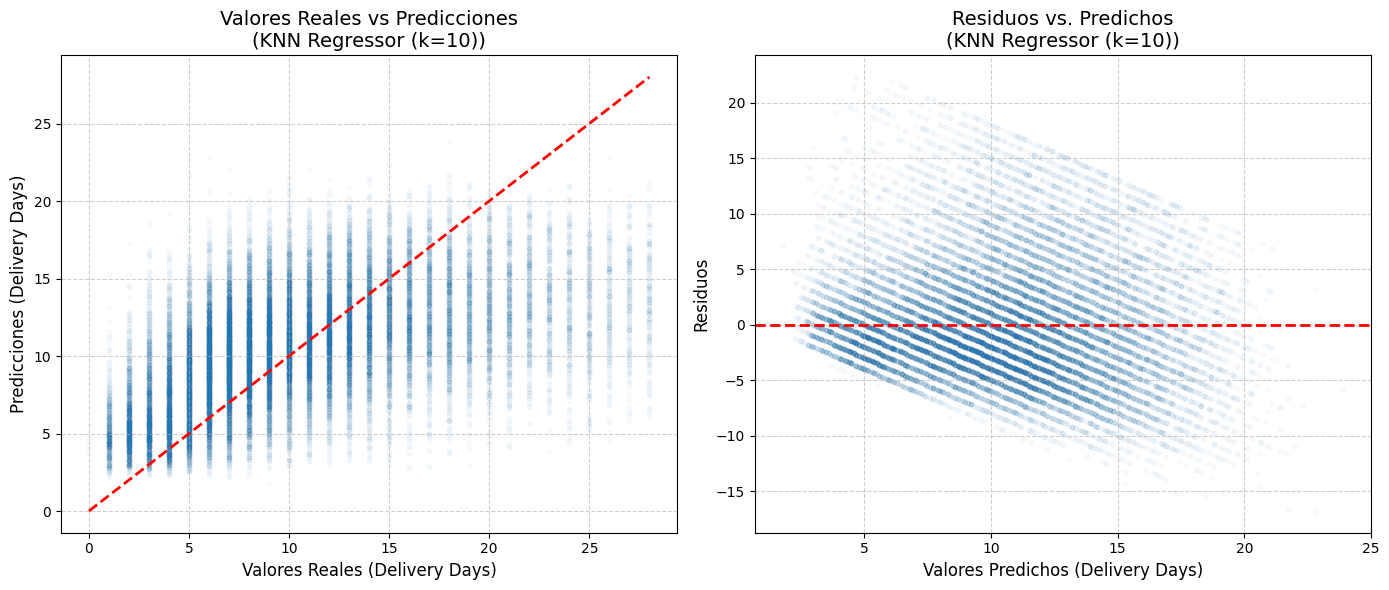


--- Evaluación de KNN Regressor (k=10) ---
Mean Squared Error (MSE):     27.059244
Root Mean Squared Error (RMSE): 5.201850
Mean Absolute Error (MAE):    4.011763
R-squared (R²):               0.259215
-------------------------------------------


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

knn_regressor = KNeighborsRegressor(n_neighbors=10)

knn_regressor.fit(X_days_train, Y_days_train)
Y_pred_knn = knn_regressor.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (k=10)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_knn,
    model_name='KNN Regressor (k=10)'
)

Este modelo ofrece una mejora significativa sobre el anterior, con un R2 de 0.26. Parece captar el trend inicial de manera correcta pero comparte algunos de los errores del modelo anterior. Observando la gráfica de residuos, sigue teniendo problema para trabajar con valores más altos de Delivery Days. Sin embargo, podemos concluir que el tener un parámetro de K más alto resultó en un modelo más preciso.

**Modelo Gridsearch con CV**

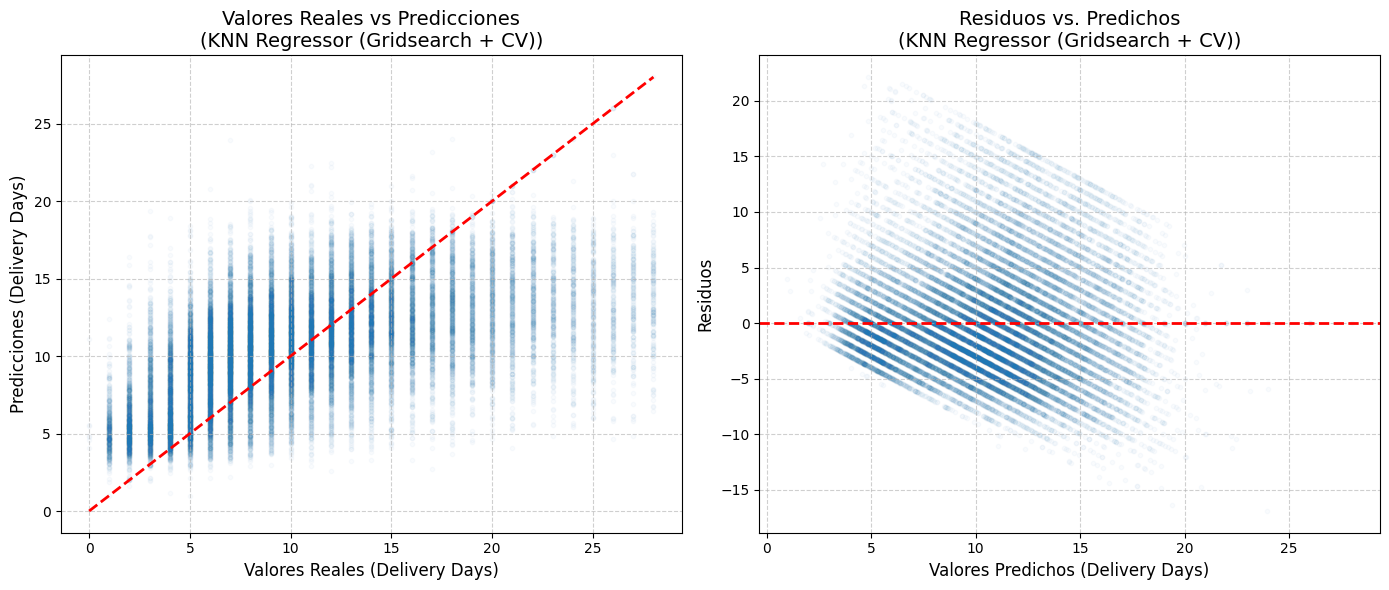


--- Evaluación de KNN Regressor (Gridsearch + CV) ---
Mean Squared Error (MSE):     25.627894
Root Mean Squared Error (RMSE): 5.062400
Mean Absolute Error (MAE):    3.886606
R-squared (R²):               0.298401
------------------------------------------------------


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import time
import numpy as np

param_grid_knn = {
    'n_neighbors': [13, 16, 19, 21, 23, 27, 30],
    'weights': ['uniform', 'distance']
}

knn_regressor_cv = KNeighborsRegressor()

grid_search_cv_knn = GridSearchCV(
    estimator=knn_regressor_cv,
    param_grid=param_grid_knn,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search_cv_knn.fit(X_days_train, Y_days_train)

best_knn_cv = grid_search_cv_knn.best_estimator_

Y_pred_cv_knn = best_knn_cv.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv_knn,
    target_column_name='Delivery Days',
    model_name='KNN Regressor (Gridsearch + CV)'
)

print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_cv_knn,
    model_name='KNN Regressor (Gridsearch + CV)'
)


El modelo utilizando validación cruzada trajo una mejora en los resultados en comparación al anterior, tiene un R2 de 0.298 en comparación a 0.26 del anterior. Esto nos indica que una validación cruzada resultó en un modelo más efectivo y que una búsqueda en un campo de parámetros más amplio también contribuyó a esto. En cuánto a la gráfica de residuales, la tendencia general (dónde la gráfica está más oscura) parece estar distribuida más uniformemente que el modelo anterior. Sin embargo, seguimos teniendo regiones más claras (menos densas) que siguen algunos patrones. Esto nos indica que el modelo sigue siendo incapaz de detectar algunos patrones dentro de nuestros datos.

**Análisis Comparativo**

En el caso de la regresión KNN, la variación de parámetros ofreció una mejora significativa sobre el modelo. Además, el explorar un espacio más amplio de parámetros utilizando Gridsearch y validación cruzada probó ser efectivo. En general, este algoritmo ofrece una precisión bastante similar a otros modelos como Random Forest a un costo computacional sumamente bajo en comparación.

## SVR

### Delivery Days

**Modelo 'Baseline'**

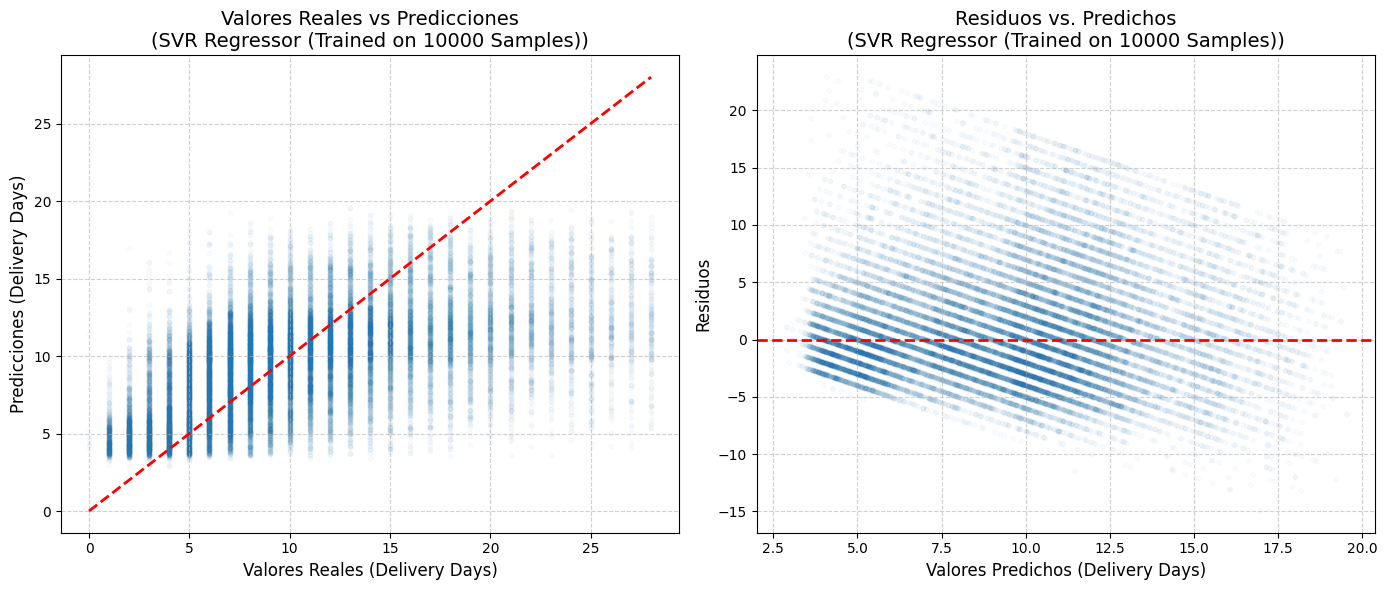


--- Evaluación de SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     26.907487
Root Mean Squared Error (RMSE): 5.187243
Mean Absolute Error (MAE):    3.858264
R-squared (R²):               0.263370
---------------------------------------------------------------


In [ ]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train


svr_regressor_sample = SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.1)

svr_regressor_sample.fit(X_train_sample, Y_train_sample)

Y_pred_svr_sample = svr_regressor_sample.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_sample,
    target_column_name='Delivery Days',
    model_name=f'SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_sample,
    model_name=f'SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)


Este modelo es el mejor modelo baseline que hemos tenido hasta el momento (R2 de 0.26), parece captar la relación entre pocos días (4-15) de manera bastante adecuada según la gráfica de predichos vs reales y la distribución de los residuales es bastante uniforme en cuánto a la concentración principal. Podemos probar con diferentes parámetros para intentar encontrar un modelo aún mejor.

**Modelo con Nuevos Parametros**

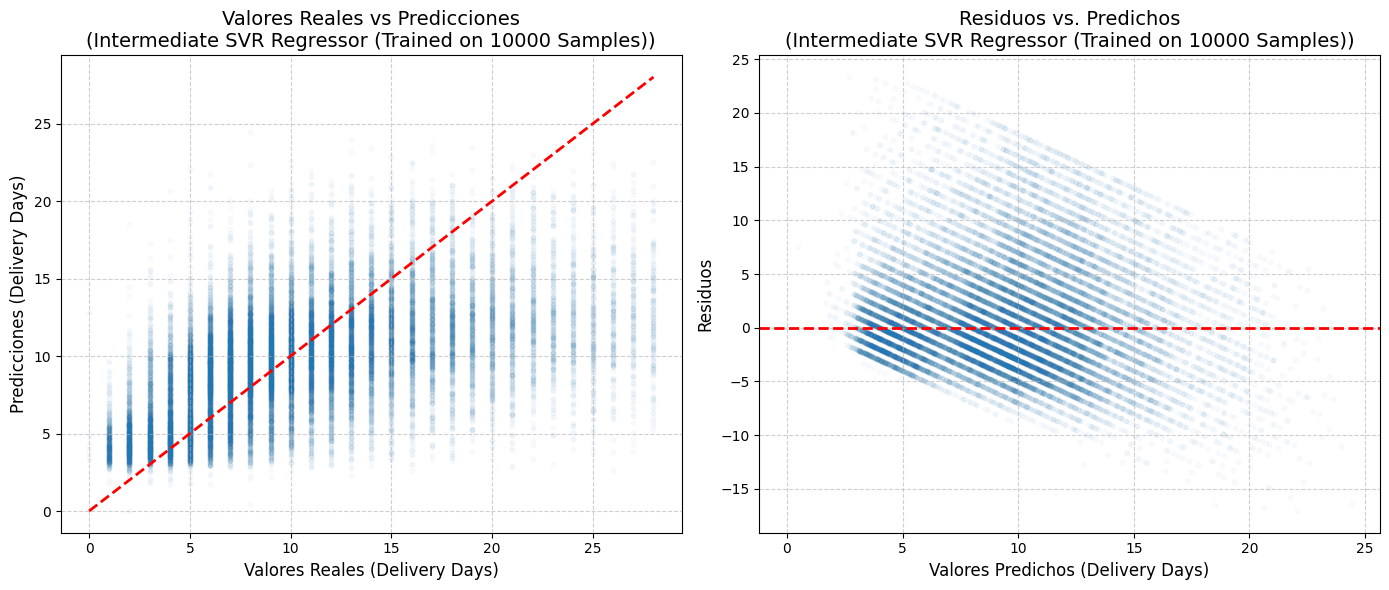


--- Evaluación de Intermediate SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     27.287108
Root Mean Squared Error (RMSE): 5.223706
Mean Absolute Error (MAE):    3.886808
R-squared (R²):               0.252977
----------------------------------------------------------------------------


In [ ]:
from sklearn.svm import SVR
import pandas as pd

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train

svr_regressor_intermediate = SVR(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    epsilon=0.05
)

svr_regressor_intermediate.fit(X_train_sample, Y_train_sample)

Y_pred_svr_intermediate = svr_regressor_intermediate.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_intermediate,
    target_column_name='Delivery Days',
    model_name=f'Intermediate SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_svr_intermediate,
    model_name=f'Intermediate SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)


Al variar los parámetros, obtenemos resultados sumamente similares a los parámetros baseline. Esto nos puede indicar dos cosas,

- Los parámetros baseline eran bastante adecuados para realizar predicciones sobre el modelo
- Debemos realizar una búsqueda más amplia sobre diferentes parámetros e implementar validación cruzada

**Gridsearch con CV**

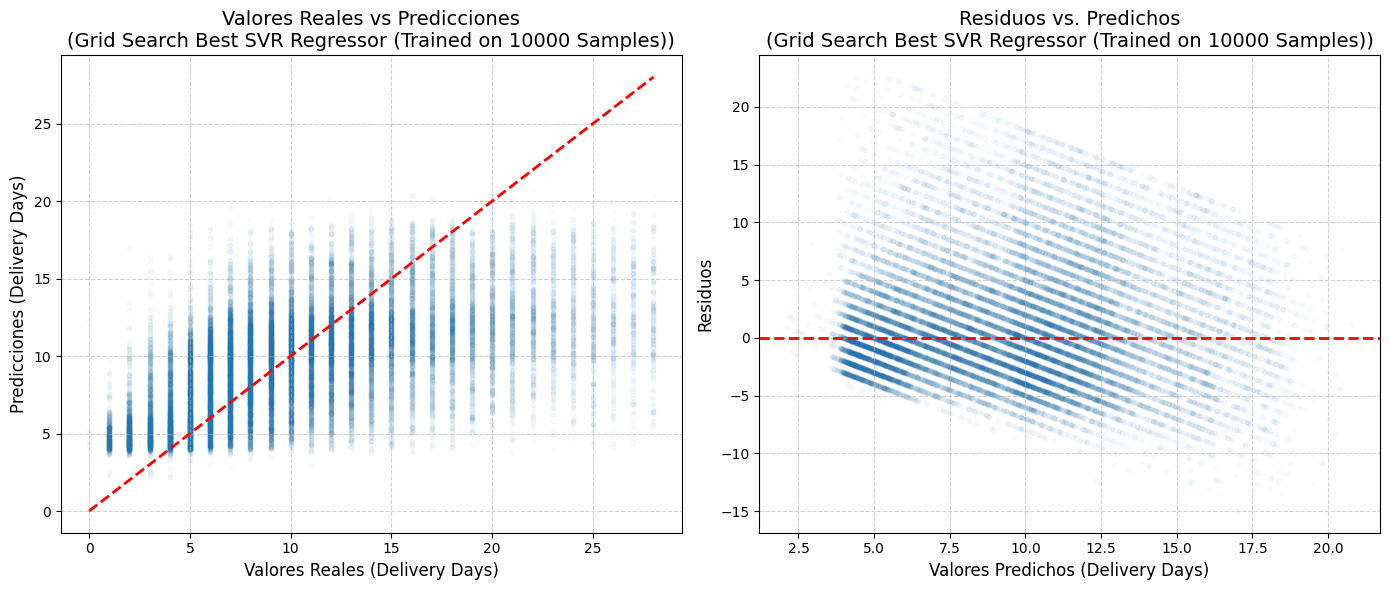


--- Evaluación de Grid Search Best SVR Regressor (Trained on 10000 Samples) ---
Mean Squared Error (MSE):     26.840644
Root Mean Squared Error (RMSE): 5.180796
Mean Absolute Error (MAE):    3.853952
R-squared (R²):               0.265200
--------------------------------------------------------------------------------


In [ ]:
from sklearn.svm import SVR
import pandas as pd
from sklearn.model_selection import GridSearchCV

sample_size = 10000
if isinstance(sample_size, int):
    if sample_size > len(X_days_train):
        X_train_sample = X_days_train
        Y_train_sample = Y_days_train
    else:
        sample_indices = X_days_train.sample(n=sample_size, random_state=42).index
        X_train_sample = X_days_train.loc[sample_indices]
        Y_train_sample = Y_days_train.loc[sample_indices]
elif isinstance(sample_size, float) and 0 < sample_size <= 1:
    X_train_sample = X_days_train.sample(frac=sample_size, random_state=42)
    Y_train_sample = Y_days_train.loc[X_train_sample.index]
else:
    X_train_sample = X_days_train
    Y_train_sample = Y_days_train


param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'epsilon': [0.01, 0.05, 0.1, 0.2, 0.5]
}

svr = SVR(kernel='rbf')

grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_sample, Y_train_sample)

best_params = grid_search.best_params_
best_svr_model = grid_search.best_estimator_

Y_pred_best_svr = best_svr_model.predict(X_days_test)

plot_regression_results(
    Y_test=Y_days_test,
    Y_pred=Y_pred_best_svr,
    target_column_name='Delivery Days',
    model_name=f'Grid Search Best SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)
print_regression_metrics(
    Y_test=Y_days_test,
    Y_pred=Y_pred_best_svr,
    model_name=f'Grid Search Best SVR Regressor (Trained on {len(X_train_sample)} Samples)'
)



El rendimiento de este modelo es marginalmente mejor a los anteriores, sigue presentando características similares. Esto nos lleva a la conclusión que los parámetros elegidos inicialmente fueron adecuados para el set de datos y que SVR puede verse afectado levemente por la variación de parámetros

**Análisis Comparativo**

El modelo base de SVR comprobó ser bastante efectivo, sin embargo, al momento de variar parámetros no se encontraron mejoras significativas. A pesar de implementar validación cruzada, los resultados fueron sumamente similares.

### Conclusiones

- El modelo más adecuado para la predicción de Delivery Days fue Random Forest.
- El implementar validación cruzada tuvo efectos positivos y tangibles dentro de Random Forest y KNN, sin embargo para SVR no se obtuvieron mejoras significativas. Esto se puede dar a una elección de parámetros iniciales más adecuada o particularidades del modelo que lo hacen menos dependiente de los parámetros.
- Ninguno de los modelos probó ser efectivo para predecir Review Score, esto nos indica que es un problema potencialmente resuelto de una manera más adecuada por medio de modelos de clasificación.

# Modelos de Clasificacion
En este seccion implementamos los modelos de clasificacion de Regresion Logistica, Arboles de Decision, Random Forest, Naive Bayes, KNN y SVM. Para cada uno de estos modelos implementamos predicciones de

- Review score, el puntaje de 1-5 dejado en los reviews de un pedido
- Satisfaccion del cliente, pedidos con un Review Score >= 4 indican un cliente satisfecho y de lo contrario insatisfecho.
- Delivery delayed, si un pedido se atrasa o no

La evaluación de los modelos se realizó por medio de curvas CAP y puntaje F1 macro ya que el Weighted favorece a los modelos que no predicen valores con menor representación

## Regresion Logistica

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for LR Baseline (Satisfaction) ---
Accuracy: 0.677867350677904
Precision: 0.7592878468789064
Recall: 0.677867350677904
F1-Score: 0.7072824392436059

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.51      0.37      5010
           1       0.87      0.72      0.78     22280

    accuracy                           0.68     27290
   macro avg       0.58      0.61      0.57     27290
weighted avg       0.76      0.68      0.71     27290

----------------------------------------------


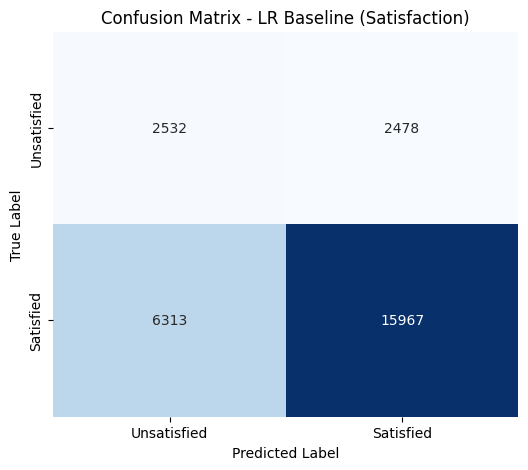

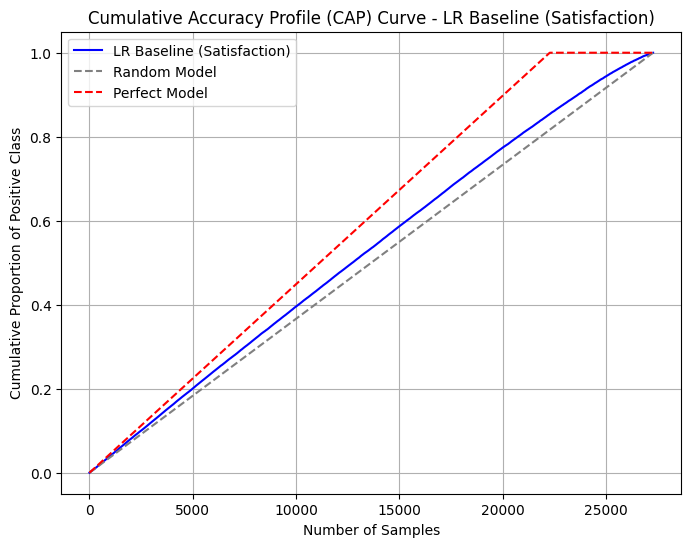

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline_lr_sat_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        random_state=42,
        C=10,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced'
    ))
])


pipeline_lr_sat_baseline.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_lr_sat_baseline = pipeline_lr_sat_baseline.predict(X_satisfaction_test)
Y_proba_lr_sat_baseline = pipeline_lr_sat_baseline.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_lr_sat_baseline,
    model_name='LR Baseline (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_lr_sat_baseline,
    model_name='LR Baseline (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_lr_sat_baseline,
    model_name='LR Baseline (Satisfaction)'
)

Este modelo inicial tuvo un desempeño muy bueno en cuánto a órdenes que llegaron a tiempo, sin embargo una gran parte de las que llegaron tarde fueron clasificadas erróneamente. Según las estadísticas clave como F1, el modelo tuvo un desempeño aceptable. Sin embargo, observando la cuva CAP encontramos que el modelo está más cercano a una curva de un modelo aleatorio que la de un modelo perfecto.

**Modelo con Parametros Modificados**


--- Metrics for LR Modified (Satisfaction) ---
Accuracy: 0.6780505679736167
Precision: 0.7593060625623557
Recall: 0.6780505679736167
F1-Score: 0.7074203479802209

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.51      0.37      5010
           1       0.87      0.72      0.78     22280

    accuracy                           0.68     27290
   macro avg       0.58      0.61      0.57     27290
weighted avg       0.76      0.68      0.71     27290

----------------------------------------------


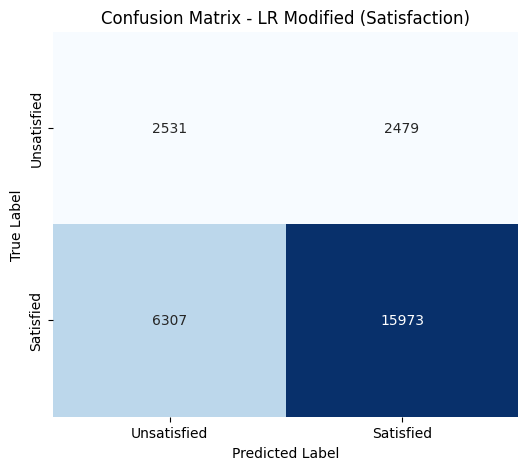

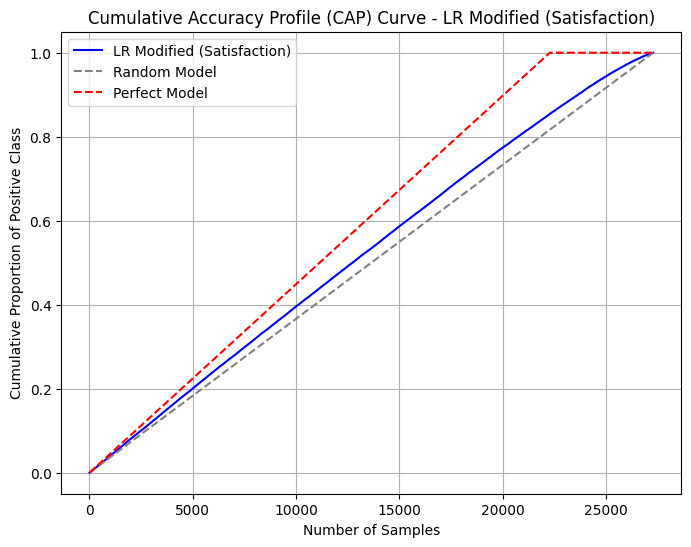

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline_lr_sat_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        random_state=42,
        C=0.5,
        penalty='l2',
        solver='liblinear',
        max_iter=2000,
        class_weight='balanced'
    ))
])
pipeline_lr_sat_mod.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_lr_sat_mod = pipeline_lr_sat_mod.predict(X_satisfaction_test)
Y_proba_lr_sat_mod = pipeline_lr_sat_mod.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_lr_sat_mod,
    model_name='LR Modified (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_lr_sat_mod,
    model_name='LR Modified (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_lr_sat_mod,
    model_name='LR Modified (Satisfaction)'
)

A pesar de haber variado los parámetros, el modelo es casi idéntico al modelo anterior. Podemos asumir que hay algún trend o información que el modelo no es capaz de captar todavía, por lo que puede requerir utilizar validación cruzada.

Best parameters found by Grid Search (Satisfaction): {'clf__C': 0.001, 'clf__max_iter': 10000, 'clf__penalty': 'l1', 'clf__solver': 'saga'}

--- Metrics for LogReg GS (Satisfaction) ---
Accuracy: 0.6940271161597655
Precision: 0.7602800553122766
Recall: 0.6940271161597655
F1-Score: 0.719126128689465

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.48      0.37      5010
           1       0.86      0.74      0.80     22280

    accuracy                           0.69     27290
   macro avg       0.58      0.61      0.58     27290
weighted avg       0.76      0.69      0.72     27290

--------------------------------------------


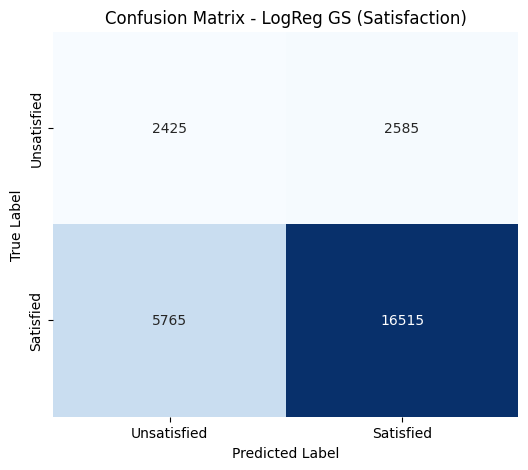

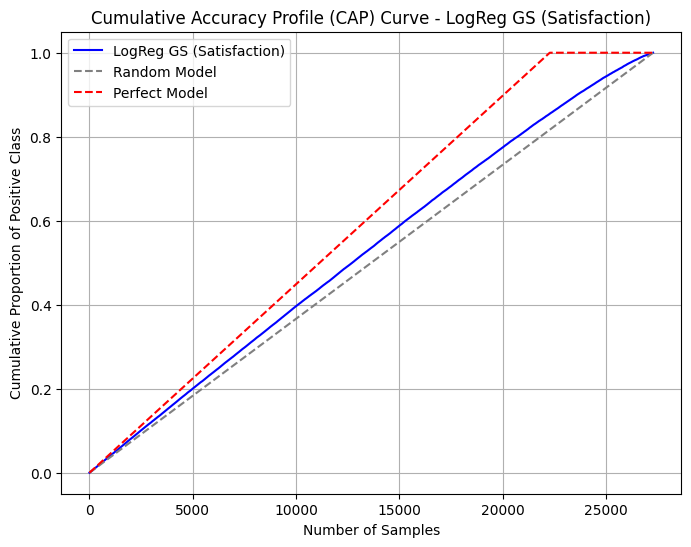

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Pipeline con SMOTE + Regresión Logística
pipeline_log_reg_sat = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Parámetros a explorar (prefijo 'clf__' para el paso del pipeline)
param_grid = {
    'clf__C':        [0.001, 0.01, 0.1, 1],
    'clf__penalty':  ['l1', 'l2'],
    'clf__solver':   ['liblinear', 'saga'],
    'clf__max_iter': [10000]
}

# F1-macro como métrica de scoring
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# GridSearchCV sobre el pipeline
grid_search_log_reg_satisfaction = GridSearchCV(
    pipeline_log_reg_sat,
    param_grid,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Ajustamos al conjunto de entrenamiento de satisfacción
grid_search_log_reg_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

# Mostramos los mejores parámetros
print("Best parameters found by Grid Search (Satisfaction):", grid_search_log_reg_satisfaction.best_params_)

# Predicciones sobre el conjunto de prueba
Y_pred_best_log_reg_satisfaction = grid_search_log_reg_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_log_reg_satisfaction = grid_search_log_reg_satisfaction.predict_proba(X_satisfaction_test)

# Imprimimos métricas y graficamos resultados
print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_log_reg_satisfaction,
    model_name='LogReg GS (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_log_reg_satisfaction,
    model_name='LogReg GS (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_log_reg_satisfaction,
    model_name='LogReg GS (Satisfaction)'
)


El modelo sigue haciendo predicciones muy similares, por lo que podemos concluir que la variación de parámetros e implementación de validación cruzada no fue efectiva.

**Análisis Comparativo**

Ambos modelos utilizando variación de parámetros al igual que validación cruzada tuvieron un desempeño pobre, esto nos lleva a teorizar que este modelo no es capaz de reconocer las relaciones detrás de los datos. Al no tener mejora alguna, puede que no hayamos explorado un espacio parametral suficientemente alto o que el modelo simplemente no se adapte a los datos.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for LR Baseline (Delivery Delayed) ---
Accuracy: 0.6796995236350312
Precision: 0.949715983093204
Recall: 0.6796995236350312
F1-Score: 0.7789202036317198

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     26289
           1       0.08      0.69      0.14      1001

    accuracy                           0.68     27290
   macro avg       0.53      0.69      0.47     27290
weighted avg       0.95      0.68      0.78     27290

--------------------------------------------------


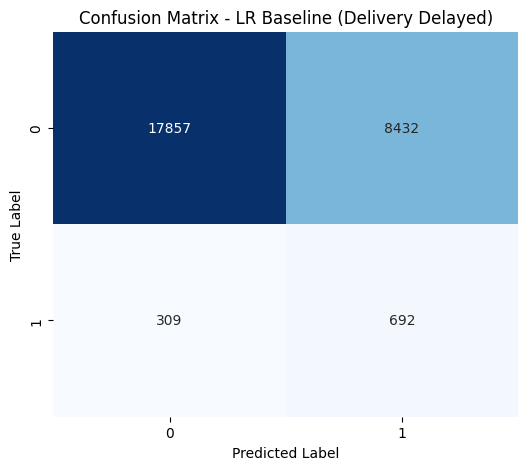

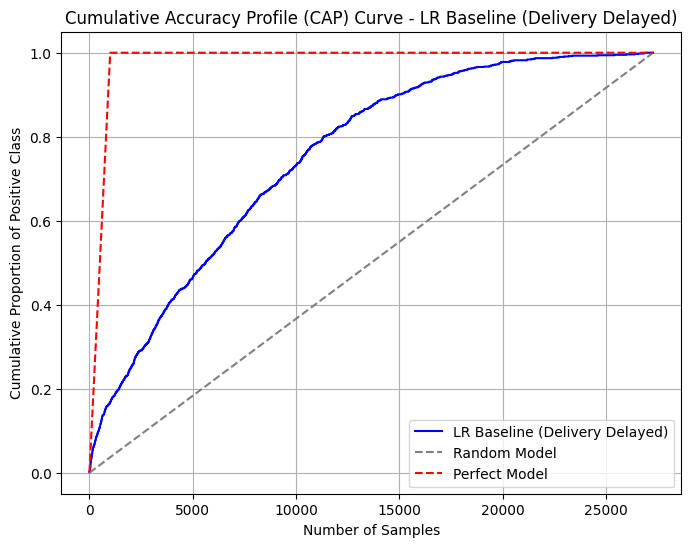

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline_lr_del_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        random_state=42,
        C=10,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        class_weight='balanced'
    ))
])
pipeline_lr_del_baseline.fit(X_delayed_train, Y_delayed_train)
Y_pred_lr_del_baseline = pipeline_lr_del_baseline.predict(X_delayed_test)
Y_proba_lr_del_baseline = pipeline_lr_del_baseline.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_lr_del_baseline,
    model_name='LR Baseline (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_lr_del_baseline,
    model_name='LR Baseline (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_lr_del_baseline,
    model_name='LR Baseline (Delivery Delayed)'
)


Este modelo parece tener estadísticas altas en cuánto a Weighted, sin embargo las estadísticas Macro indican un mal rendimiento. Observando la curva CAP, el modelo está por encima del punto medio entre las curvas aleatorias y perfectas. Estos resultados no son estelares, pero por otro lado podemos intentar variar los parámetros para obtener resultados más precisos.

**Modelo con Parametros Modificados**


--- Metrics for LR Modified (Delivery Delayed) ---
Accuracy: 0.6800659582264565
Precision: 0.949728050616854
Recall: 0.6800659582264565
F1-Score: 0.7791844056050657

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     26289
           1       0.08      0.69      0.14      1001

    accuracy                           0.68     27290
   macro avg       0.53      0.69      0.47     27290
weighted avg       0.95      0.68      0.78     27290

--------------------------------------------------


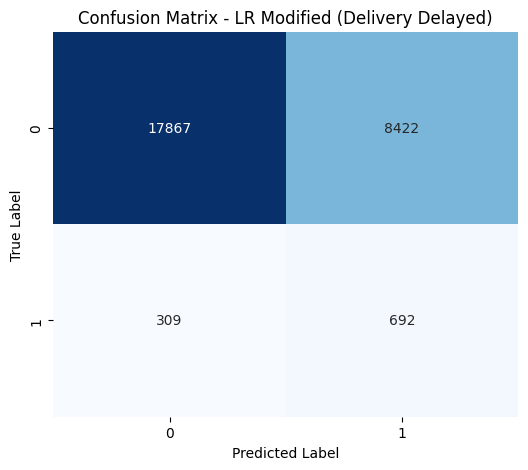

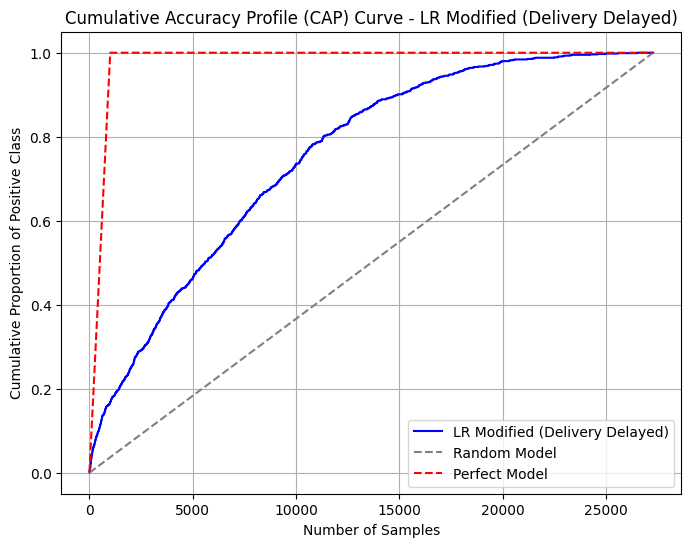

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline_lr_del_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        random_state=42,
        C=0.5,
        penalty='l2',
        solver='liblinear',
        max_iter=2000,
        class_weight='balanced'
    ))
])
pipeline_lr_del_mod.fit(X_delayed_train, Y_delayed_train)
Y_pred_lr_del_mod = pipeline_lr_del_mod.predict(X_delayed_test)
Y_proba_lr_del_mod = pipeline_lr_del_mod.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_lr_del_mod,
    model_name='LR Modified (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_lr_del_mod,
    model_name='LR Modified (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_lr_del_mod,
    model_name='LR Modified (Delivery Delayed)'
)

A pesar de incluir parámetros diferentes, las predicciones fueron prácticamente las mismas. Esto nos inclina más hacia poder acertar que el modelo no es el adecuado para los datos. Sin embargo, podemos seguir explorando utilizando Grid Search y validación cruzada.

**Modelo con Validacion Cruzada**

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Creamos un pipeline que primero aplica SMOTE y luego la regresión logística
pipeline_log_reg_delayed = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Definimos la malla de parámetros para el paso 'clf' del pipeline
param_grid = {
    'clf__C':        [0.001, 0.01, 0.1, 1],
    'clf__penalty':  ['l1', 'l2'],
    'clf__solver':   ['liblinear', 'saga'],
    'clf__max_iter': [10000]
}

# Métrica F1-macro para evaluar en GridSearch
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# GridSearchCV sobre el pipeline
grid_search_log_reg_delayed = GridSearchCV(
    pipeline_log_reg_delayed,
    param_grid,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Ajustamos al conjunto de entrenamiento de Delivery Delayed
grid_search_log_reg_delayed.fit(X_delayed_train, Y_delayed_train)

# Mostramos los mejores parámetros encontrados
print("Best parameters found by Grid Search (Delivery Delayed):", grid_search_log_reg_delayed.best_params_)

# Realizamos predicciones sobre el conjunto de prueba
Y_pred_best_log_reg_delayed = grid_search_log_reg_delayed.predict(X_delayed_test)
Y_pred_proba_best_log_reg_delayed = grid_search_log_reg_delayed.predict_proba(X_delayed_test)

# Imprimimos métricas y graficamos matrices y CAP curve
print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_log_reg_delayed,
    model_name='LogReg GS (Delivery Delayed)'
)

plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_log_reg_delayed,
    model_name='LogReg GS (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)

plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_log_reg_delayed,
    model_name='LogReg GS (Delivery Delayed)'
)


KeyboardInterrupt: 

Al observar los resultados, son principalmente idénticos a los modelos anteriores. Por lo que podemos asumir que este modelo no es el adecuado para los datos, la validación cruzada no nos ayudó a encontrar parámetros óptimos.

**Análisis Comparativo**

Los resultados son casi idénticos, y tomando en cuenta los resultados de las clasificaciones anteriores, la variación de parámetros y validación cruzada utilizando este modelo es poco efectiva. Es muy probable que se encuentren resultados similares utilizando los parámetros por defecto en comparación a realizar búsqueda a mayor profundidad o espacio parametral.

## Random Forest

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for RF Baseline (Satisfaction) ---
Accuracy: 0.5118772950313587
Precision: 0.48843001611561754
Recall: 0.5118772950313587
F1-Score: 0.498306865830827

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.32      0.32      6347
           1       0.21      0.15      0.18      6061
           2       0.64      0.70      0.67     18365

    accuracy                           0.51     30773
   macro avg       0.39      0.39      0.39     30773
weighted avg       0.49      0.51      0.50     30773

----------------------------------------------


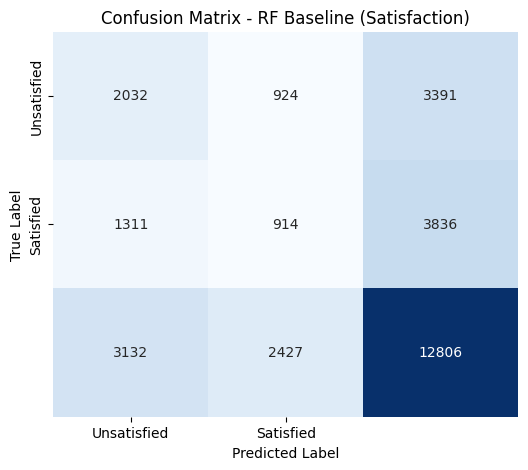

In [47]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf_sat_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=3,
        class_weight='balanced'
    ))
])
pipeline_rf_sat_baseline.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_rf_sat_baseline = pipeline_rf_sat_baseline.predict(X_satisfaction_test)
Y_proba_rf_sat_baseline = pipeline_rf_sat_baseline.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_rf_sat_baseline,
    model_name='RF Baseline (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_rf_sat_baseline,
    model_name='RF Baseline (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)

Al igual que el inciso anterior, el Random Forest con parámetros iniciales es completamente incapaz de realizar predicciones. Por lo que vamos a proceder a modificar los parámetros

**Modelo con Parametros Modificados**

Exception ignored in: <function ResourceTracker.__del__ at 0x7c2be227d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes



--- Metrics for RF Modified (Satisfaction) ---
Accuracy: 0.7580432392817882
Precision: 0.7635572285364989
Recall: 0.7580432392817882
F1-Score: 0.760714144926667

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      5010
           1       0.86      0.85      0.85     22280

    accuracy                           0.76     27290
   macro avg       0.60      0.61      0.61     27290
weighted avg       0.76      0.76      0.76     27290

----------------------------------------------


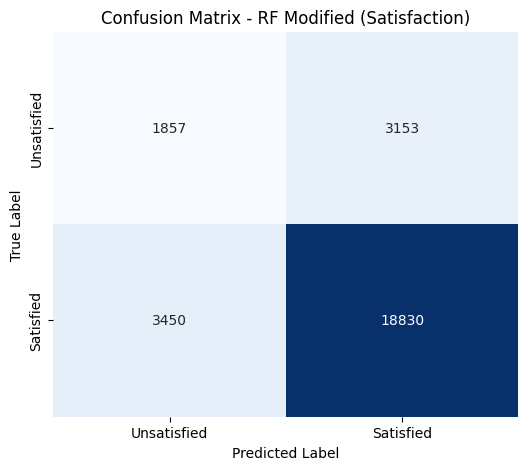

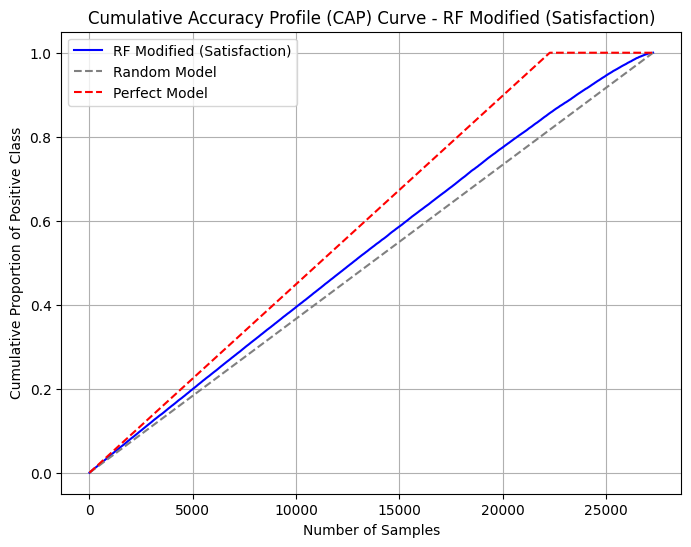

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf_sat_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=10,
        class_weight='balanced'
    ))
])
pipeline_rf_sat_mod.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_rf_sat_mod = pipeline_rf_sat_mod.predict(X_satisfaction_test)
Y_proba_rf_sat_mod = pipeline_rf_sat_mod.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_rf_sat_mod,
    model_name='RF Modified (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_rf_sat_mod,
    model_name='RF Modified (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_rf_sat_mod,
    model_name='RF Modified (Satisfaction)'
)


Con los parámetros modificados, logramos tener una curva CAP más separada de la línea de un modelo aleatorio. Además, las predicciones ya son más variadas y presenta un Macro F1 más alto.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Metrics for Random Forest Grid Search Best (Satisfaction - F1-macro) ---
Accuracy: 0.8233052400146574
Precision: 0.7890076621871215
Recall: 0.8233052400146574
F1-Score: 0.7697982293099698

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.11      0.19      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.72      0.55      0.54     27290
weighted avg       0.79      0.82      0.77     27290

----------------------------------------------------------------------------


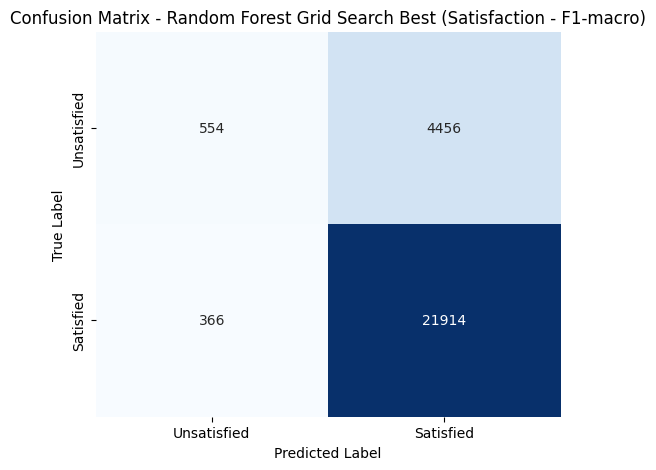

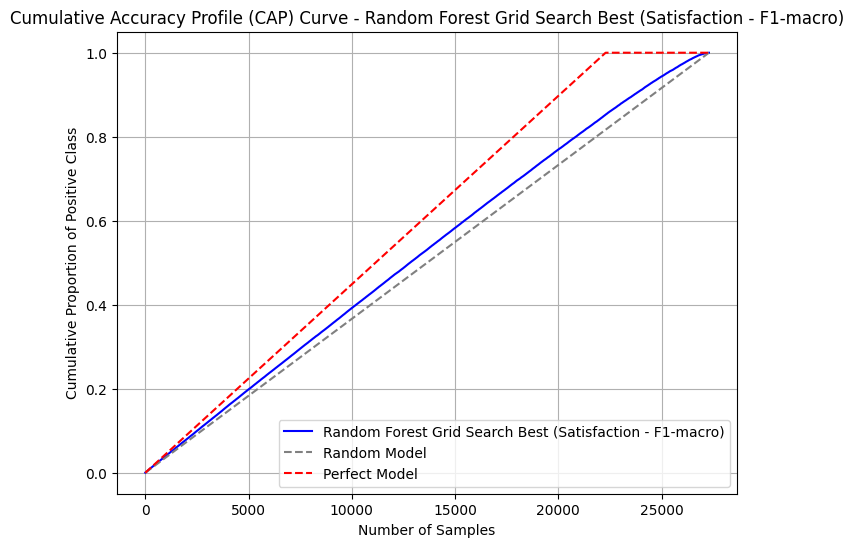

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Pipeline con SMOTE + Random Forest
pipeline_rf_satisfaction = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Parámetros para el paso 'clf' en el pipeline
param_grid = {
    'clf__n_estimators':      [100, 200],
    'clf__max_depth':         [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf':  [1, 2]
}

# Scorer F1-macro
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# GridSearchCV sobre el pipeline
grid_search_rf_satisfaction = GridSearchCV(
    pipeline_rf_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Entrenar
grid_search_rf_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

# Parámetros óptimos
print("Best parameters found by Grid Search (Satisfaction):", grid_search_rf_satisfaction.best_params_)

# Predicciones en test
Y_pred_best_rf_satisfaction = grid_search_rf_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_rf_satisfaction = grid_search_rf_satisfaction.predict_proba(X_satisfaction_test)

# Métricas y gráficas
print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_rf_satisfaction,
    model_name='RF GS (Satisfaction)'
)

plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_rf_satisfaction,
    model_name='RF GS (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_rf_satisfaction,
    model_name='RF GS (Satisfaction)'
)


Este modelo sigue primariamente prediciendo clientes satisfechos, sin embargo logró predecir de manera correcta los clientes no satisfechos con mayor frecuencia en comparación a no tener validación cruzada. Además, tuvo algunas ganancias en comparación a modelos anteriores.

**Análisis Comparativo**

El implementar validación cruzada para este modelo mejoró los números significativamente, sin embargo sigue sin poder hacer predicciones súmamente precisas. El caso fue idéntico al anterior, por lo que nos inclinamos a afirmar que la variación de parámetros utilizando Random Forest es sumamente valiosa.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for RF Baseline (Delivery Delayed) ---
Accuracy: 0.5406009527299377
Precision: 0.9522855216797549
Recall: 0.5406009527299377
F1-Score: 0.6687889337254465

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     26289
           1       0.06      0.81      0.11      1001

    accuracy                           0.54     27290
   macro avg       0.52      0.67      0.40     27290
weighted avg       0.95      0.54      0.67     27290

--------------------------------------------------


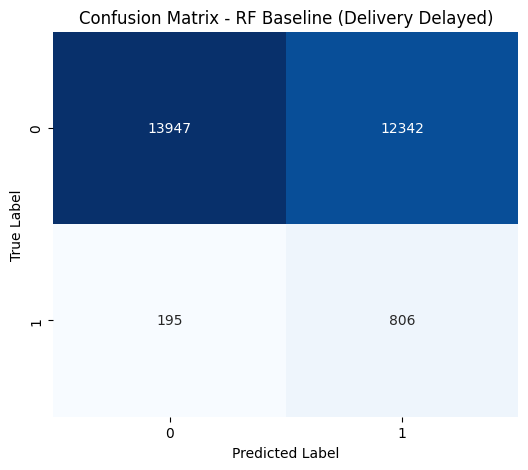

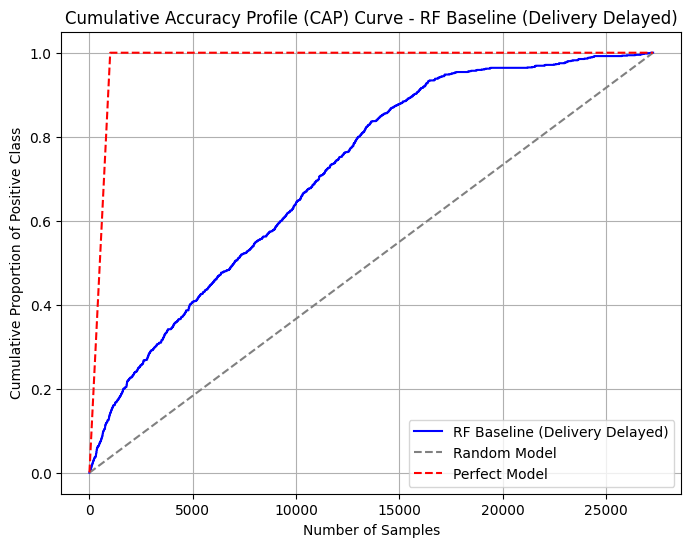

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf_delayed_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=3,
        class_weight='balanced'
    ))
])
pipeline_rf_delayed_baseline.fit(X_delayed_train, Y_delayed_train)
Y_pred_rf_delayed_baseline = pipeline_rf_delayed_baseline.predict(X_delayed_test)
Y_proba_rf_delayed_baseline = pipeline_rf_delayed_baseline.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_rf_delayed_baseline,
    model_name='RF Baseline (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_rf_delayed_baseline,
    model_name='RF Baseline (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_rf_delayed_baseline,
    model_name='RF Baseline (Delivery Delayed)'
)

De manera similar a los incisos anteriores, este modelo es completamente incapaz de hacer predicciones. Devuelve el mismo valor para todos, así que no tiene valor alguno como modelo.

**Modelo con Parametros Modificados**


--- Metrics for RF Modified (Delivery Delayed) ---
Accuracy: 0.6293147673140345
Precision: 0.9498226913464967
Recall: 0.6293147673140345
F1-Score: 0.7413755102727357

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.63      0.76     26289
           1       0.07      0.72      0.13      1001

    accuracy                           0.63     27290
   macro avg       0.53      0.67      0.44     27290
weighted avg       0.95      0.63      0.74     27290

--------------------------------------------------


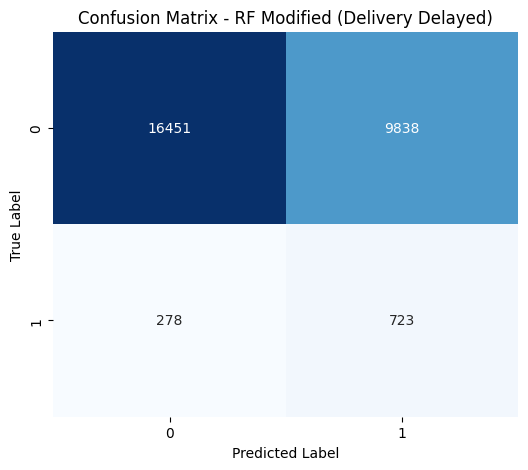

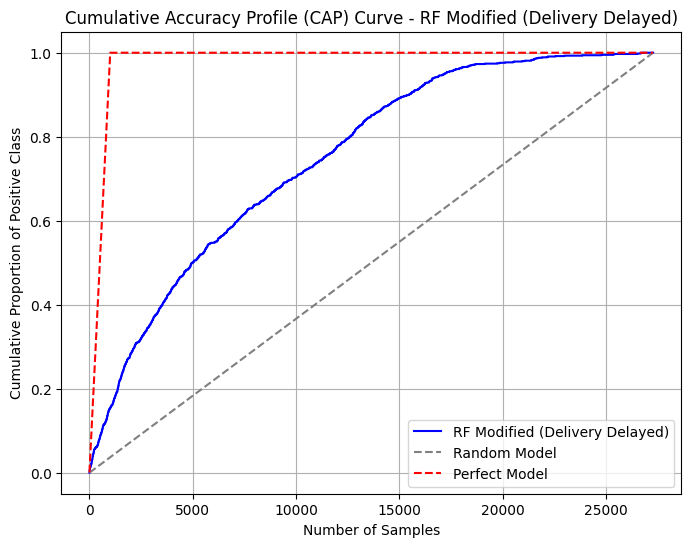

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rf_delayed_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=10,
        class_weight='balanced'
    ))
])
pipeline_rf_delayed_mod.fit(X_delayed_train, Y_delayed_train)
Y_pred_rf_delayed_mod = pipeline_rf_delayed_mod.predict(X_delayed_test)
Y_proba_rf_delayed_mod = pipeline_rf_delayed_mod.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_rf_delayed_mod,
    model_name='RF Modified (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_rf_delayed_mod,
    model_name='RF Modified (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_rf_delayed_mod,
    model_name='RF Modified (Delivery Delayed)'
)


A pesar de haber variado los parámetros, este modelo sigue sufriendo de manera idéntica al anterior. Las predicciones son las mismas para todos los datos, por lo que podemos afirmar que no es capaz de detectar relación alguna.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Metrics for Random Forest Grid Search Best (Delivery Delayed - F1-macro) ---
Accuracy: 0.9628801758886039
Precision: 0.9415611033446678
Recall: 0.9628801758886039
F1-Score: 0.9461474826846568

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.36      0.01      0.03      1001

    accuracy                           0.96     27290
   macro avg       0.66      0.51      0.50     27290
weighted avg       0.94      0.96      0.95     27290

--------------------------------------------------------------------------------


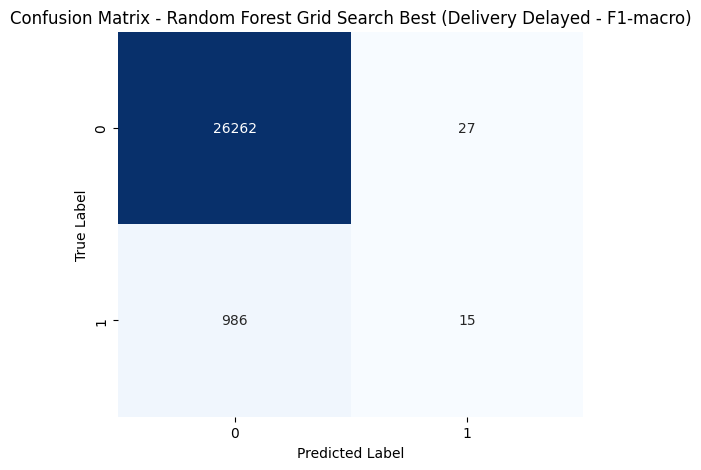

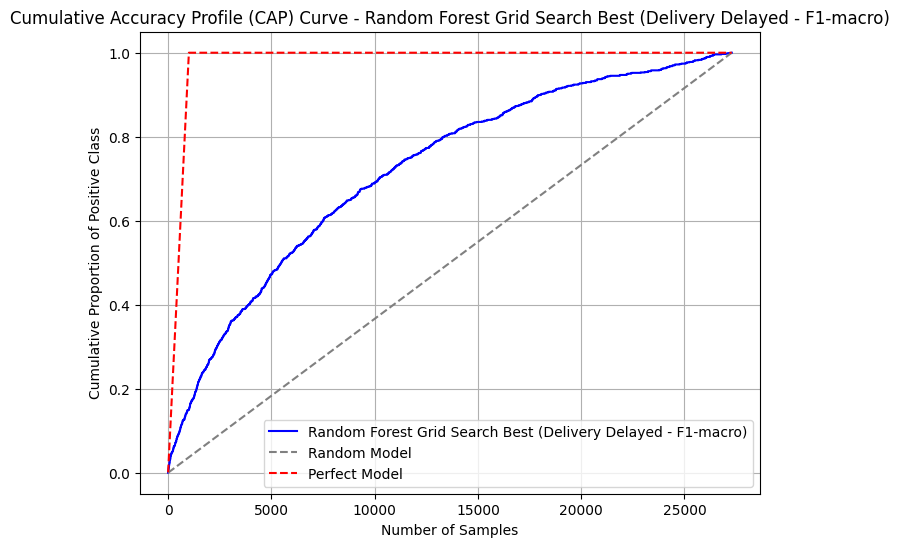

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Creamos un pipeline que primero aplica SMOTE y luego Random Forest
pipeline_rf_delayed = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Parámetros a explorar para el paso 'clf'
param_grid = {
    'clf__n_estimators':      [100, 200],
    'clf__max_depth':         [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf':  [1, 2]
}

# Usamos F1-macro como métrica de scoring
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# Configuramos GridSearchCV sobre el pipeline
grid_search_rf_delayed = GridSearchCV(
    pipeline_rf_delayed,
    param_grid,
    cv=4,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Ajustamos al conjunto de entrenamiento de Delivery Delayed
grid_search_rf_delayed.fit(X_delayed_train, Y_delayed_train)

# Imprimimos los mejores parámetros
print("Best parameters found by Grid Search (Delivery Delayed):", grid_search_rf_delayed.best_params_)

# Realizamos predicciones sobre el conjunto de prueba
Y_pred_best_rf_delayed = grid_search_rf_delayed.predict(X_delayed_test)
Y_pred_proba_best_rf_delayed = grid_search_rf_delayed.predict_proba(X_delayed_test)

# Evaluamos e imprimimos métricas
print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_rf_delayed,
    model_name='RF GS (Delivery Delayed)'
)

# Matriz de confusión
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_rf_delayed,
    model_name='RF GS (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)

# Curva CAP
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_rf_delayed,
    model_name='RF GS (Delivery Delayed)'
)


Este modelo ya empieza a generar predicciones de deliveries que se atrasaron, por lo que es superior a los anteriores. Además, es el modelo más preciso hasta el momento según las métricas Macro y Weighed. Observando la curva CAP, se encuentra ligeramente por encima del punto medio entre la curva aleatoria y la perfecta.

**Análisis Comparativo**

La aplicación de validación cruzada fue el factor clave en obtener un modelo predictor, ya que los modelos anteriores fueron incapaces de realizar predicciones. Concluyendo sobre la validación cruzada en Random Forest, esta es crucial al momento de trabajar con este clasificador y siempre debe tomarse en cuenta.

## Naive Bayes

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for NB Baseline (Satisfaction) ---
Accuracy: 0.2294868878562376
Precision: 0.5021549681872802
Recall: 0.2294868878562376
F1-Score: 0.15069442322939292

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.05      0.10      6347
           1       0.20      0.92      0.33      6061
           2       0.64      0.06      0.11     18365

    accuracy                           0.23     30773
   macro avg       0.41      0.35      0.18     30773
weighted avg       0.50      0.23      0.15     30773

----------------------------------------------


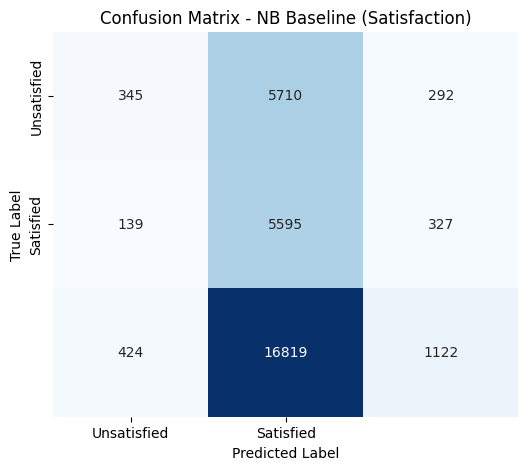

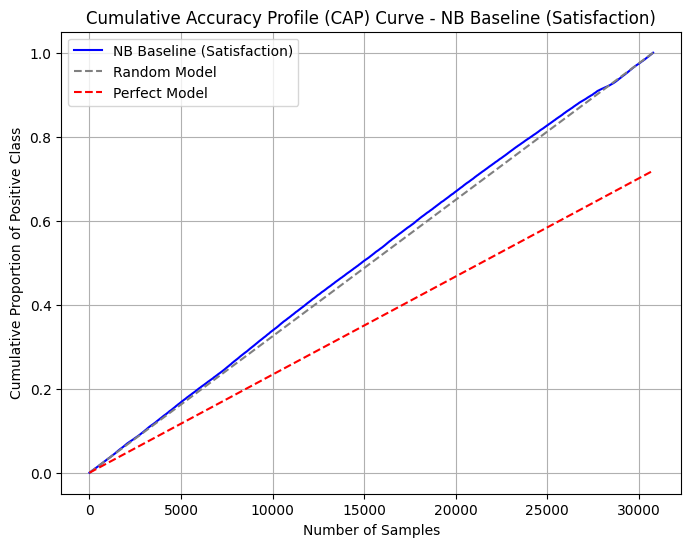

In [ ]:
from sklearn.naive_bayes import GaussianNB

pipeline_nb_sat_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])
pipeline_nb_sat_baseline.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_nb_sat_baseline = pipeline_nb_sat_baseline.predict(X_satisfaction_test)
Y_proba_nb_sat_baseline = pipeline_nb_sat_baseline.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_nb_sat_baseline,
    model_name='NB Baseline (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_nb_sat_baseline,
    model_name='NB Baseline (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_nb_sat_baseline,
    model_name='NB Baseline (Satisfaction)'
)

Este modelo parece tener un desempeño bastante alto, especialmente considerando que es el modelo baseline. A pesar de no tener una curva CAP ideal, el modelo tiene puntajes Macro comparables a las versiones finales de algunos modelos anteriores.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search (NB Satisfaction): {'clf__var_smoothing': np.float64(0.8111308307896871)}

--- Metrics for NB GS (Satisfaction) ---
Accuracy: 0.378806096253209
Precision: 0.514141164680444
Recall: 0.378806096253209
F1-Score: 0.39117997746396

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.13      0.20      6347
           1       0.21      0.63      0.32      6061
           2       0.65      0.38      0.48     18365

    accuracy                           0.38     30773
   macro avg       0.42      0.38      0.33     30773
weighted avg       0.51      0.38      0.39     30773

----------------------------------------


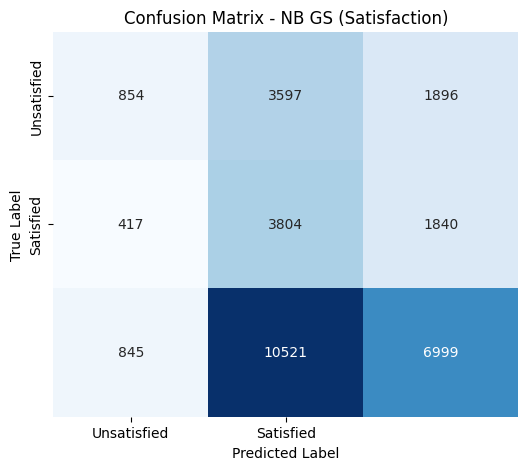

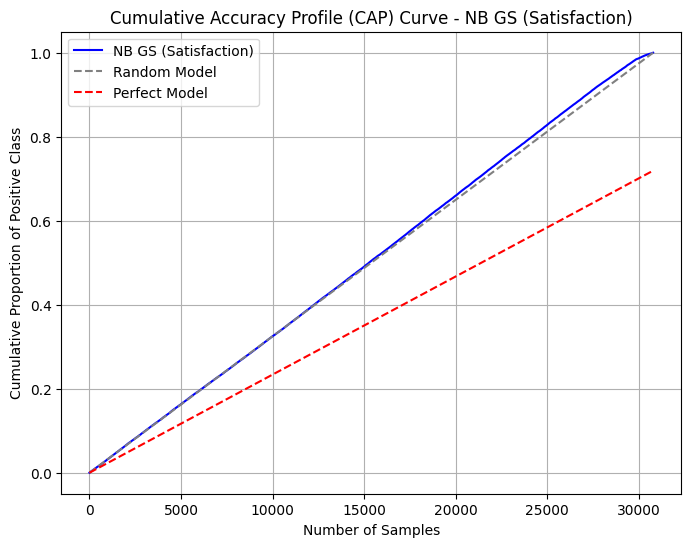

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Pipeline que aplica SMOTE y luego GaussianNB
pipeline_nb_satisfaction = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])

# Parámetros para el paso 'clf' en el pipeline
param_grid = {
    'clf__var_smoothing': np.logspace(0, -9, num=100)
}

# F1-macro como métrica de scoring
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# GridSearchCV sobre el pipeline
grid_search_nb_satisfaction = GridSearchCV(
    pipeline_nb_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Entrenamos con los datos de satisfacción
grid_search_nb_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

# Mostramos los mejores parámetros
print("Best parameters found by Grid Search (NB Satisfaction):", grid_search_nb_satisfaction.best_params_)

# Predicciones en el conjunto de prueba
Y_pred_best_nb_satisfaction = grid_search_nb_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_nb_satisfaction = grid_search_nb_satisfaction.predict_proba(X_satisfaction_test)

# Evaluamos e imprimimos métricas
print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_nb_satisfaction,
    model_name='NB GS (Satisfaction)'
)

# Matriz de confusión
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_nb_satisfaction,
    model_name='NB GS (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

# Curva CAP
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_nb_satisfaction,
    model_name='NB GS (Satisfaction)'
)


Luego de realizar un Gridsearch, el performance del modelo incrementó. Esto se puede observar en cada una de las métricas, sin embargo la curva CAP sigue similar. Para esta clasificación, Naive Bayes es el mejor modelo que hemos encontrado hasta el momento

**Análisis Comparativo**

Naive Bayes tuvo un alto rendimiento en ambas versiones, sin embargo encontramos valor al aplicar validación cruzada ya que obtuvimos mejores métricas Macro. Esto nos indica que a pesar de la distribución tan desigual, el modelo logró realizar predicciones para ambas categorías.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for NB Baseline (Delivery Delayed) ---
Accuracy: 0.09486991572004397
Precision: 0.9483046190473492
Recall: 0.09486991572004397
F1-Score: 0.11414005670757686

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.06      0.12     26289
           1       0.04      0.97      0.07      1001

    accuracy                           0.09     27290
   macro avg       0.51      0.52      0.09     27290
weighted avg       0.95      0.09      0.11     27290

--------------------------------------------------


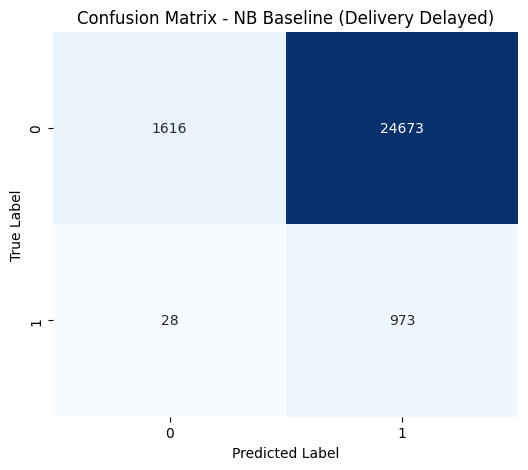

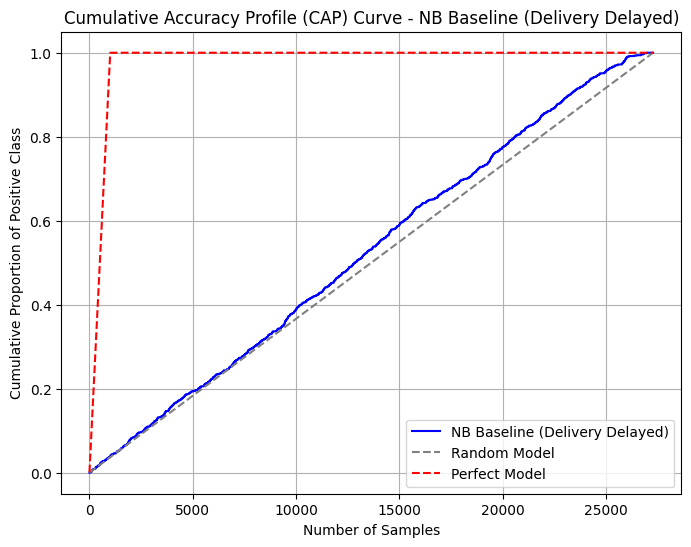

In [ ]:
from sklearn.naive_bayes import GaussianNB

pipeline_nb_del_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])
pipeline_nb_del_baseline.fit(X_delayed_train, Y_delayed_train)
Y_pred_nb_del_baseline = pipeline_nb_del_baseline.predict(X_delayed_test)
Y_proba_nb_del_baseline = pipeline_nb_del_baseline.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_nb_del_baseline,
    model_name='NB Baseline (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_nb_del_baseline,
    model_name='NB Baseline (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_nb_del_baseline,
    model_name='NB Baseline (Delivery Delayed)'
)

Este modelo tuvo un rendimiento sumamente pobre, tomando en cuenta los incisos anteriores este es un resultado poco esperado. A lo largo del inicio de la gráfica, se mueve jsutamente con un modelo completamente aleatorio y no parece acercarse para nada a un modelo ideal.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'var_smoothing': np.float64(0.03511191734215131)}

--- Metrics for Gaussian Naive Bayes Grid Search Best (Delivery Delayed - F1-macro) ---
Accuracy: 0.9164162696958593
Precision: 0.9330616653864047
Recall: 0.9164162696958593
F1-Score: 0.9245041800104424

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     26289
           1       0.08      0.12      0.09      1001

    accuracy                           0.92     27290
   macro avg       0.52      0.53      0.52     27290
weighted avg       0.93      0.92      0.92     27290

---------------------------------------------------------------------------------------


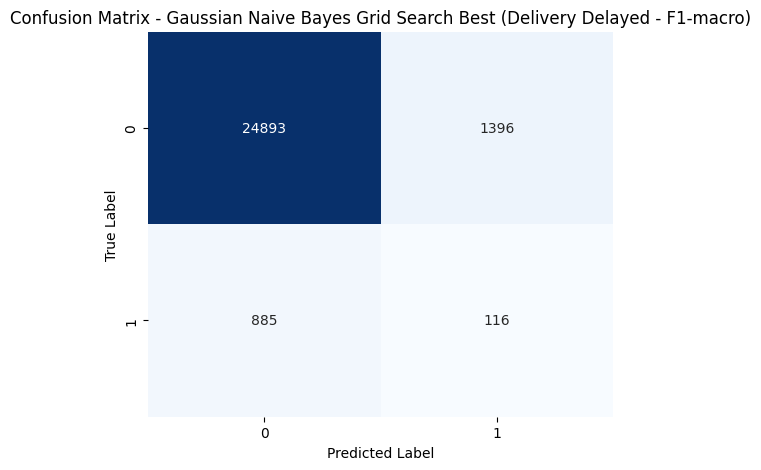

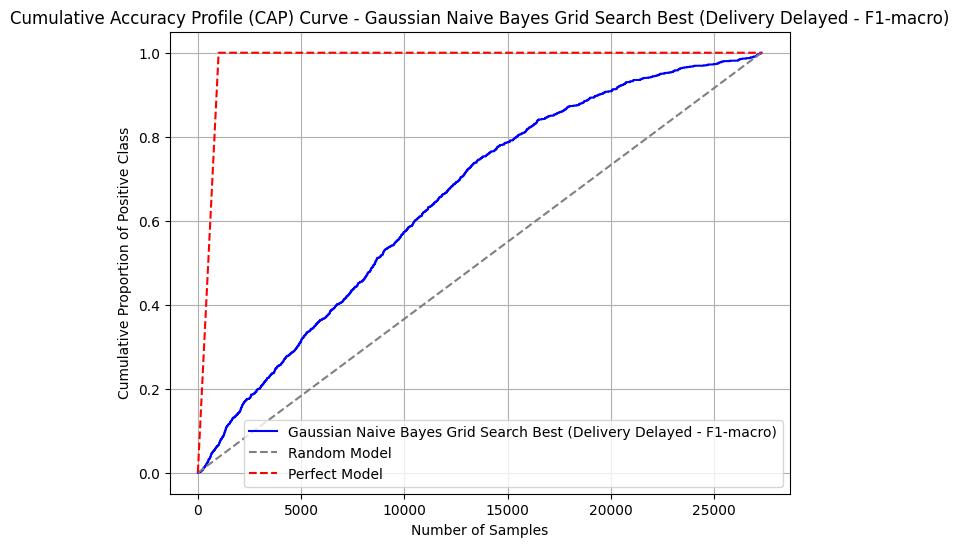

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# Pipeline que aplica SMOTE para balancear y luego GaussianNB
pipeline_nb_delayed = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', GaussianNB())
])

# Parámetros para ajustar en el paso 'clf' del pipeline
param_grid = {
    'clf__var_smoothing': np.logspace(0, -9, num=100)
}

# Definimos F1-macro como métrica de scoring
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# Configuramos GridSearchCV sobre el pipeline completo
grid_search_nb_delayed = GridSearchCV(
    pipeline_nb_delayed,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# Entrenamos con X_delayed_train y Y_delayed_train
grid_search_nb_delayed.fit(X_delayed_train, Y_delayed_train)

# Mostramos los mejores parámetros encontrados
print("Best parameters found by Grid Search (NB Delivery Delayed):", grid_search_nb_delayed.best_params_)

# Hacemos predicciones sobre el conjunto de prueba
Y_pred_best_nb_delayed = grid_search_nb_delayed.predict(X_delayed_test)
Y_pred_proba_best_nb_delayed = grid_search_nb_delayed.predict_proba(X_delayed_test)

# Evaluamos el modelo encontrado
print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_nb_delayed,
    model_name='NB GS (Delivery Delayed)'
)

# Matriz de confusión
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_nb_delayed,
    model_name='NB GS (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)

# Curva CAP
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_nb_delayed,
    model_name='NB GS (Delivery Delayed)'
)


Al implementar validación cruzada, podemos observar una diferencia clara de rendimiento entre los modelos dentro de la curva CAP. Este se distancia completamente de la curva del modelo aleatorio, y sus métricas son comparables a modelos anteriores.

**Análisis Comparativo**

Hay una diferencia claramente marcada, al implementar validación cruzada se fue de un rendimiento similar a un modelo aleatorio a un modelo que si puede realizar predicciones. Sin embargo, se sigue lejos de la curva ideal.

## KNN

### Satisfaccion del Cliente

**Modelo Baseline**


--- Metrics for KNN Baseline (Satisfaction) ---
Accuracy: 0.6024551117625504
Precision: 0.7315012183740164
Recall: 0.6024551117625504
F1-Score: 0.6453840247722039

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.49      0.31      5010
           1       0.84      0.63      0.72     22280

    accuracy                           0.60     27290
   macro avg       0.54      0.56      0.52     27290
weighted avg       0.73      0.60      0.65     27290

-----------------------------------------------


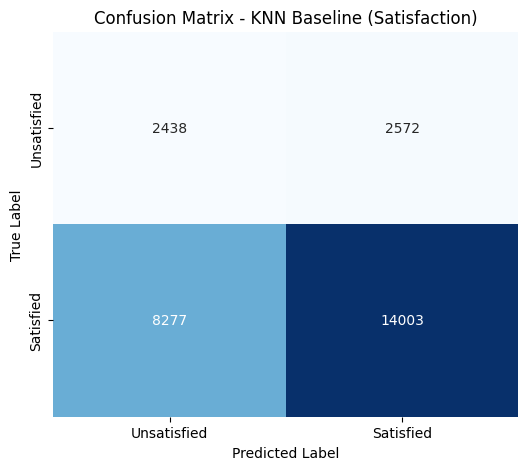

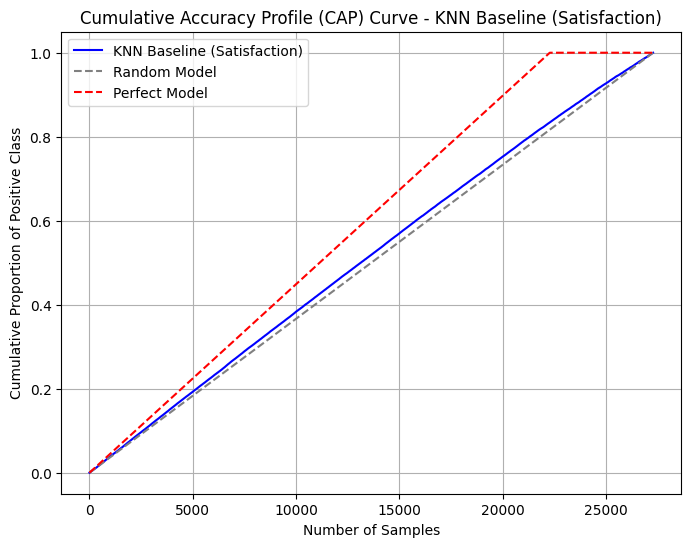

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn_sat_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])
pipeline_knn_sat_baseline.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_knn_sat_baseline = pipeline_knn_sat_baseline.predict(X_satisfaction_test)
Y_proba_knn_sat_baseline = pipeline_knn_sat_baseline.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_knn_sat_baseline,
    model_name='KNN Baseline (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_knn_sat_baseline,
    model_name='KNN Baseline (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_knn_sat_baseline,
    model_name='KNN Baseline (Satisfaction)'
)

El modelo Baseline de KNN es similar al de NB, dónde el modelo no sufre de centrarse en las predicciones más altamente representadas dentro del set de datos. Sin embargo, observando la curva CAP nos podemos dar cuenta que el rendimiento es similar a un modelo aleatorio.

**Modelo con Parametros Modificados**


--- Metrics for KNN Modified (Satisfaction) ---
Accuracy: 0.588127519237816
Precision: 0.7388336480853718
Recall: 0.588127519237816
F1-Score: 0.6341341947003646

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.54      0.32      5010
           1       0.85      0.60      0.70     22280

    accuracy                           0.59     27290
   macro avg       0.54      0.57      0.51     27290
weighted avg       0.74      0.59      0.63     27290

-----------------------------------------------


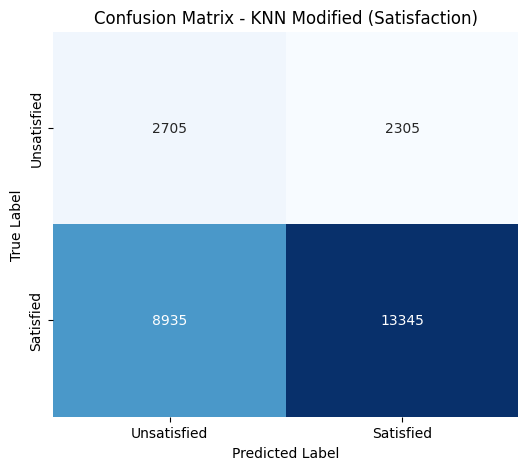

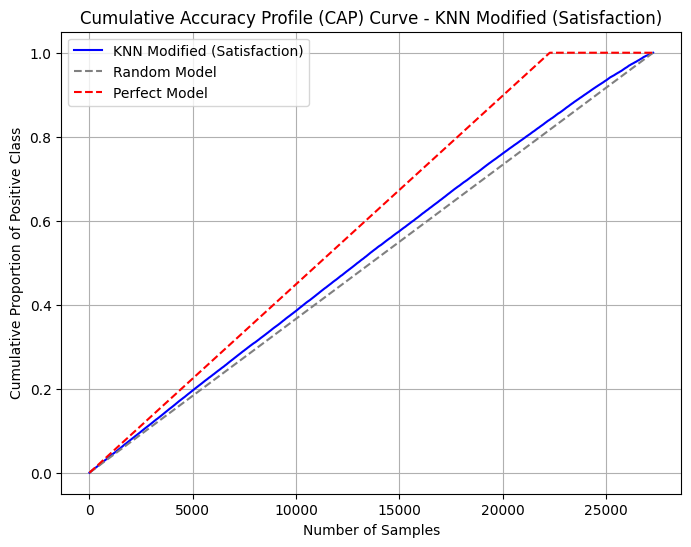

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn_sat_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=15, weights='distance'))
])
pipeline_knn_sat_mod.fit(X_satisfaction_train, Y_satisfaction_train)
Y_pred_knn_sat_mod = pipeline_knn_sat_mod.predict(X_satisfaction_test)
Y_proba_knn_sat_mod = pipeline_knn_sat_mod.predict_proba(X_satisfaction_test)

print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_knn_sat_mod,
    model_name='KNN Modified (Satisfaction)'
)
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_knn_sat_mod,
    model_name='KNN Modified (Satisfaction)',
    classes=['Unsatisfied','Satisfied']
)
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_proba_knn_sat_mod,
    model_name='KNN Modified (Satisfaction)'
)


Variando los parámetros, observamos una mejora en cuánto a la curva CAP y las métricas ponen a este modelo con un rendimiento similar a los demás.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}

--- Metrics for KNN Grid Search Best (Satisfaction - F1-macro) ---
Accuracy: 0.7966288017588861
Precision: 0.7473766139270532
Recall: 0.7966288017588861
F1-Score: 0.7611351926526237

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.16      0.22      5010
           1       0.83      0.94      0.88     22280

    accuracy                           0.80     27290
   macro avg       0.60      0.55      0.55     27290
weighted avg       0.75      0.80      0.76     27290

------------------------------------------------------------------


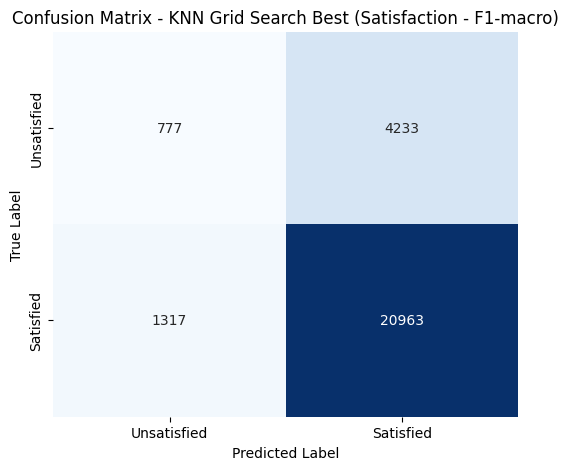

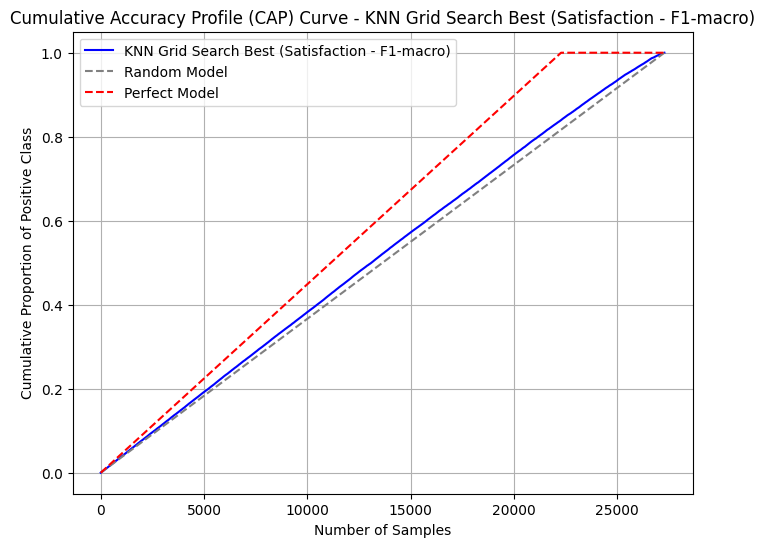

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 1) Creamos un pipeline que primero aplica SMOTE y luego entrena el clasificador KNN
pipeline_knn_satisfaction = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier())
])

# 2) Definimos la grilla de parámetros para el paso 'clf' dentro del pipeline
param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25],
    'clf__weights':     ['uniform', 'distance'],
    'clf__metric':      ['euclidean', 'manhattan']
}

# 3) Usamos F1-macro como métrica de scoring
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

# 4) Configuramos GridSearchCV sobre el pipeline completo
grid_search_knn_satisfaction = GridSearchCV(
    pipeline_knn_satisfaction,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# 5) Entrenamos con los datos de satisfacción
grid_search_knn_satisfaction.fit(X_satisfaction_train, Y_satisfaction_train)

# 6) Imprimimos los mejores parámetros encontrados
print("Best parameters found by Grid Search (KNN Satisfaction):", 
      grid_search_knn_satisfaction.best_params_)

# 7) Hacemos predicciones sobre el conjunto de prueba
Y_pred_best_knn_satisfaction      = grid_search_knn_satisfaction.predict(X_satisfaction_test)
Y_pred_proba_best_knn_satisfaction = grid_search_knn_satisfaction.predict_proba(X_satisfaction_test)

# 8) Evaluamos e imprimimos métricas de clasificación
print_classification_metrics(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_knn_satisfaction,
    model_name='KNN GS (Satisfaction)'
)

# 9) Mostramos la matriz de confusión
plot_confusion_matrix(
    Y_test=Y_satisfaction_test,
    Y_pred=Y_pred_best_knn_satisfaction,
    model_name='KNN GS (Satisfaction)',
    classes=['Unsatisfied', 'Satisfied']
)

# 10) Trazamos la curva CAP
plot_cap_curve(
    Y_test=Y_satisfaction_test,
    Y_pred_proba=Y_pred_proba_best_knn_satisfaction,
    model_name='KNN GS (Satisfaction)'
)


Al realizar un Gridsearch con validación cruzada observamos una ligera mejora en el modelo, sin embargo la curva CAP nos sigue indicando que en general el modelo es bastante pobre. Por lo cuál podemos afirmar que el modelo no se adaptó al conjunto de datos o no exploramos un espacio parametral lo suficientemente amplio.

### Delivery Delayed

**Modelo Baseline**


--- Metrics for KNN Baseline (Delivery Delayed) ---
Accuracy: 0.8212898497618175
Precision: 0.938983703670282
Recall: 0.8212898497618175
F1-Score: 0.8721253432322388

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     26289
           1       0.08      0.36      0.13      1001

    accuracy                           0.82     27290
   macro avg       0.53      0.60      0.51     27290
weighted avg       0.94      0.82      0.87     27290

---------------------------------------------------


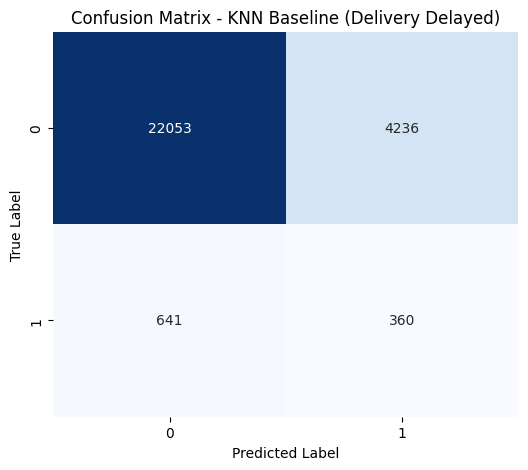

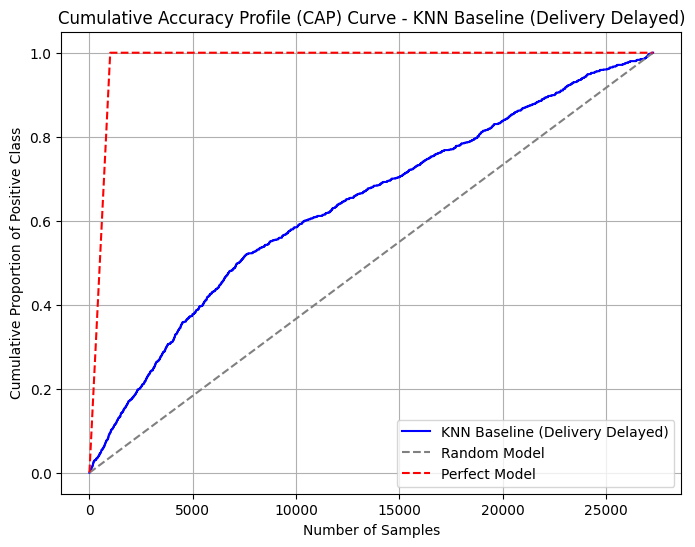

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn_del_baseline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])
pipeline_knn_del_baseline.fit(X_delayed_train, Y_delayed_train)
Y_pred_knn_del_baseline = pipeline_knn_del_baseline.predict(X_delayed_test)
Y_proba_knn_del_baseline = pipeline_knn_del_baseline.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_knn_del_baseline,
    model_name='KNN Baseline (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_knn_del_baseline,
    model_name='KNN Baseline (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_knn_del_baseline,
    model_name='KNN Baseline (Delivery Delayed)'
)

El modelo baseline de KNN tuvo un rendimiento bastante bueno en comparación a los demás, en los modelos anteriores este normalmente tenía un rendimiento similar al aleatorio. Al variar los parámetros esperamos encontrar resultados positivos.

**Modelo con Parametros Modificados**


--- Metrics for KNN Modified (Delivery Delayed) ---
Accuracy: 0.765921582997435
Precision: 0.9416920115599078
Recall: 0.765921582997435
F1-Score: 0.8377969933890609

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.78      0.86     26289
           1       0.07      0.47      0.13      1001

    accuracy                           0.77     27290
   macro avg       0.52      0.62      0.50     27290
weighted avg       0.94      0.77      0.84     27290

---------------------------------------------------


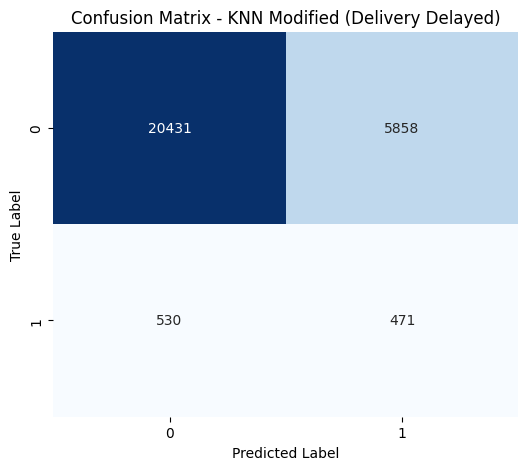

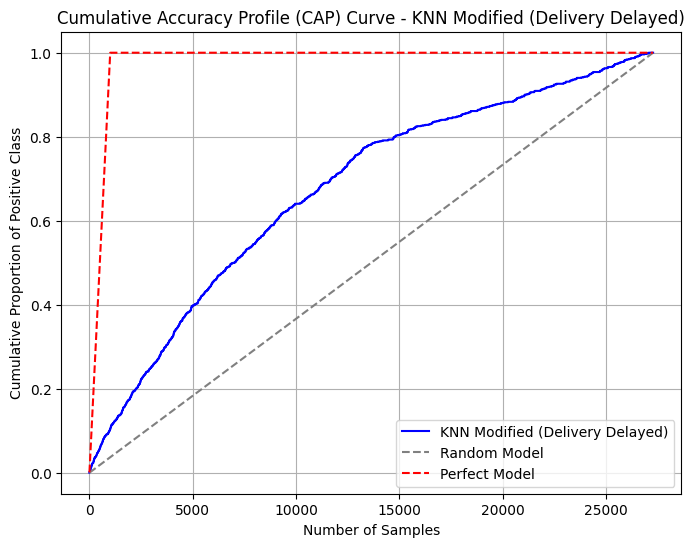

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn_del_mod = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier(n_neighbors=15, weights='distance'))
])
pipeline_knn_del_mod.fit(X_delayed_train, Y_delayed_train)
Y_pred_knn_del_mod = pipeline_knn_del_mod.predict(X_delayed_test)
Y_proba_knn_del_mod = pipeline_knn_del_mod.predict_proba(X_delayed_test)

print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_knn_del_mod,
    model_name='KNN Modified (Delivery Delayed)'
)
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_knn_del_mod,
    model_name='KNN Modified (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_proba_knn_del_mod,
    model_name='KNN Modified (Delivery Delayed)'
)


En este modelo empezamos a ver cómo existe una mayor tendencia a apuntar hacia deliveries a tiempo, esto da una mejor precisión del modelo pero sigue sin tener mucho recall para los valores de deliveries atrasados.

**Modelo con Gridsearch y CV**

Best parameters found by Grid Search (KNN Delivery Delayed): {'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'distance'}

--- Metrics for KNN GS (Delivery Delayed) ---
Accuracy: 0.8711615976548186
Precision: 0.9366063388547484
Recall: 0.8711615976548186
F1-Score: 0.9009149146994803

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     26289
           1       0.08      0.25      0.12      1001

    accuracy                           0.87     27290
   macro avg       0.53      0.57      0.53     27290
weighted avg       0.94      0.87      0.90     27290

---------------------------------------------


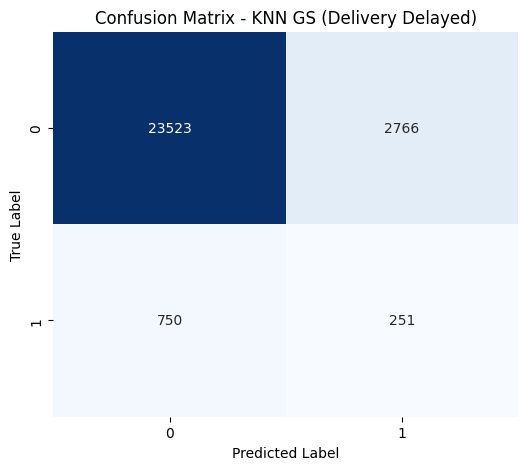

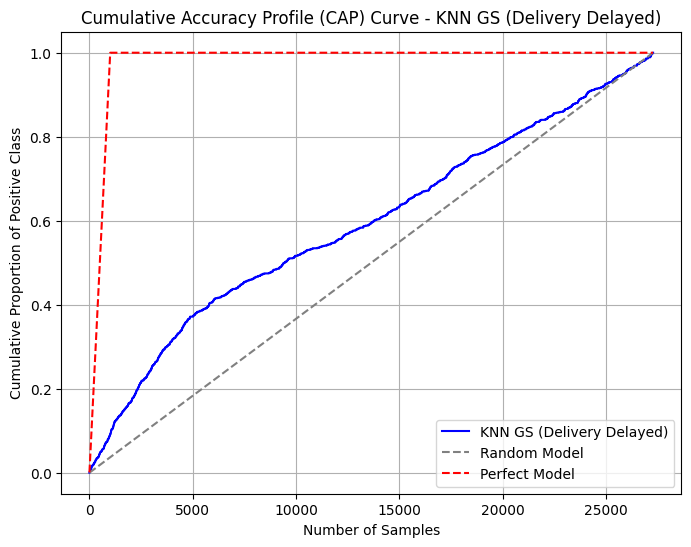

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# 1) Creamos un pipeline que primero balancea con SMOTE y luego aplica KNN
pipeline_knn_delayed = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier())
])

# 2) Definimos la grilla de hiperparámetros para el clasificador dentro del pipeline
param_grid = {
    'clf__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 20, 25],
    'clf__weights':     ['uniform', 'distance'],
    'clf__metric':      ['euclidean', 'manhattan']
}

# 3) Usamos F1-macro como métrica de scoring para GridSearchCV
f1_macro_scorer = make_scorer(f1_score, average='weighted', zero_division=0)

grid_search_knn_delayed = GridSearchCV(
    pipeline_knn_delayed,
    param_grid,
    cv=3,
    scoring=f1_macro_scorer,
    n_jobs=-1
)

# 4) Entrenamos el GridSearch con los datos de entrenamiento
grid_search_knn_delayed.fit(X_delayed_train, Y_delayed_train)

# 5) Imprimimos los mejores parámetros
print("Best parameters found by Grid Search (KNN Delivery Delayed):", 
      grid_search_knn_delayed.best_params_)

# 6) Realizamos predicciones con el mejor modelo hallado
Y_pred_best_knn_delayed      = grid_search_knn_delayed.predict(X_delayed_test)
Y_pred_proba_best_knn_delayed = grid_search_knn_delayed.predict_proba(X_delayed_test)

# 7) Evaluamos el desempeño
print_classification_metrics(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_knn_delayed,
    model_name='KNN GS (Delivery Delayed)'
)

# 8) Matriz de confusión
plot_confusion_matrix(
    Y_test=Y_delayed_test,
    Y_pred=Y_pred_best_knn_delayed,
    model_name='KNN GS (Delivery Delayed)',
    classes=sorted(Y_delayed_test.unique())
)

# 9) Curva CAP
plot_cap_curve(
    Y_test=Y_delayed_test,
    Y_pred_proba=Y_pred_proba_best_knn_delayed,
    model_name='KNN GS (Delivery Delayed)'
)


Este modelo empieza prometedor, sin embargo al final empieza a tener un rendimiento similar al de un modelo aleatorio. Esto nos indica que el modelo no logró captar la información proveída por los datos.

**Análisis Comparativo**

El aplicar validación cruzada no resultó en lo esperado, ya que no se logró obtener un modelo adecuado. Sin embargo, en este caso en específico podríamos argumentar que la métrica con la que se evalúa el modelo puede afectar la validación cruzada. Ya que algunas métricas aumentaron a pesar de que la curva CAP no vió mejora alguna.

## Conclusiones

- En algunos modelos como Random Forest, consideramos que es crucial realizar un proceso de validación cruzada para explorar espacios parametrales amplios
- Es de suma importancia utilizar las métricas correctas para obtener buenos resultados al aplicar validación cruzada.
- En general, Random Forest fue el mejor predictor para cada una de nuestras variables categóricas.
- La distribución de las variables objetivo tienen un efecto muy marcado sobre los modelos.
- NB es una alternativa completamente viable con bajo costo computacional.

# Redes Neuronales
Dentro de este Jupyter Notebook, aplicamos redes neuronales para intentar crear modelos de clasificación y regresión sobre el dataset de Olist. Dentro de ellos:

- Modelos de Regresion
    - Prediccion de Review Score, a pesar de ser mas un problema de clasificacion decidimos incluirlo dentro de regresiones para tener un analisis comparativo

- Modelos de Clasificacion
    - Prediccion de Review Score
    - Prediccion de Delivery Delayed, para pedidos atrasados
    - Prediccion de Satisfaccion del Cliente, 4+ en Review Score = Satisfecho. No satisfecho de lo contrario

Antes de empezar, podemos cargar el Dataset y limpiarlos ligeramente para evitar data leakage

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
# Removed explicit import of StandardScaler here
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score # Import evaluation metrics


df = pd.read_csv('dataset/cleaned_orders.csv')
df = df.dropna()

dfreview = df.copy()
dfdays = df.copy()
dfdelayed = df.copy()

dfdays.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dfdelayed.drop(columns=['delivery_days', 'delivery_delta', 'review_score'], inplace=True)

review_train, review_test = train_test_split(
    dfreview,
    test_size=0.3,
    stratify=dfreview['review_score'],
    random_state=42
)

days_train, days_test = train_test_split(
    dfdays,
    test_size=0.3,
    random_state=42
)

delayed_train, delayed_test = train_test_split(
    dfdelayed,
    test_size=0.3,
    random_state=42
)

Y_review_train = review_train['review_score']
X_review_train = review_train.drop(columns=['review_score'])
Y_review_test = review_test['review_score']
X_review_test = review_test.drop(columns=['review_score'])

Y_days_train = days_train['delivery_days']
X_days_train = days_train.drop(columns=['delivery_days'])
Y_days_test = days_test['delivery_days']
X_days_test = days_test.drop(columns=['delivery_days'])

Y_delayed_train = delayed_train['delivery_delayed']
X_delayed_train = delayed_train.drop(columns=['delivery_delayed'])
Y_delayed_test = delayed_test['delivery_delayed']
X_delayed_test = delayed_test.drop(columns=['delivery_delayed'])

Y_satisfaction_train = (Y_review_train >= 4).astype(int)
Y_satisfaction_test = (Y_review_test >= 4).astype(int)
X_satisfaction_train = X_review_train.copy()
X_satisfaction_test = X_review_test.copy()

numeric_cols = X_satisfaction_train.select_dtypes(include=np.number).columns.tolist()

binary_cols = []
for col in X_satisfaction_train.columns:
    if X_satisfaction_train[col].nunique() <= 2:
        binary_cols.append(col)

true_numeric_cols = [col for col in numeric_cols if col not in binary_cols]

categorical_cols = X_satisfaction_train.select_dtypes(include='object').columns.tolist()

print("True Numeric columns:", true_numeric_cols)
print("Binary/Potential One-Hot columns (<= 2 distinct values):", binary_cols)
print("Categorical columns (if any):", categorical_cols)

True Numeric columns: ['estimated_delivery_days', 'delivery_days', 'delivery_delta', 'avg_product_price', 'total_order_price', 'item_count', 'order_freight_value', 'freight_to_price', 'shipping_distance_km', 'payment_installments', 'product_size_factor']
Binary/Potential One-Hot columns (<= 2 distinct values): ['delivery_delayed', 'different_state', 'seller_state_AM', 'seller_state_BA', 'seller_state_CE', 'seller_state_DF', 'seller_state_ES', 'seller_state_GO', 'seller_state_MA', 'seller_state_MG', 'seller_state_MS', 'seller_state_MT', 'seller_state_PA', 'seller_state_PB', 'seller_state_PE', 'seller_state_PI', 'seller_state_PR', 'seller_state_RJ', 'seller_state_RN', 'seller_state_RO', 'seller_state_RS', 'seller_state_SC', 'seller_state_SE', 'seller_state_SP', 'customer_state_AC', 'customer_state_AL', 'customer_state_AM', 'customer_state_AP', 'customer_state_BA', 'customer_state_CE', 'customer_state_DF', 'customer_state_ES', 'customer_state_GO', 'customer_state_MA', 'customer_state_MG',

Podemos definir una funcion de utilidad para distinguir columnas numericas que necesitamos escalar, a diferencia de las one-hot-encoded.

In [ ]:
def get_column_types(dataframe):

    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()

    binary_cols = []
    for col in dataframe.columns:
        try:
            if dataframe[col].nunique() <= 2:
                binary_cols.append(col)
        except TypeError:
            pass

    true_numeric_cols = [col for col in numeric_cols if col not in binary_cols]

    categorical_cols = dataframe.select_dtypes(include='object').columns.tolist()

    return true_numeric_cols, binary_cols, categorical_cols

In [ ]:
def plot_regression_results(Y_test, Y_pred, target_column_name="Target", model_name="Model"):
    residuals = Y_test - Y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(Y_test, Y_pred,
                    alpha=0.025,
                    s=10)
    min_val = min(Y_test.min(), Y_pred.min())
    max_val = max(Y_test.max(), Y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel(f"Valores Reales ({target_column_name})", fontsize=12)
    axes[0].set_ylabel(f"Predicciones ({target_column_name})", fontsize=12)
    axes[0].set_title(f"Valores Reales vs Predicciones\n({model_name})", fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(Y_pred, residuals,
                    alpha=0.025,
                    s=10)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel(f"Valores Predichos ({target_column_name})", fontsize=12)
    axes[1].set_ylabel("Residuos", fontsize=12)
    axes[1].set_title(f"Residuos vs. Predichos\n({model_name})", fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def print_regression_metrics(Y_test, Y_pred, model_name="Model"):
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mse)

    print(f"\n--- Evaluación de {model_name} ---")
    print(f"Mean Squared Error (MSE):     {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE):    {mae:.6f}")
    print(f"R-squared (R²):               {r2:.6f}")
    print("-" * (len(f"--- Evaluación del {model_name} ---")))

# Clasificación

## Review Score

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [ ]:
true_numeric_cols_review, binary_cols_review, categorical_cols_review = get_column_types(X_review_train)

preprocessing_steps_review = []

if true_numeric_cols_review:
    preprocessing_steps_review.append(('standard_scaler', StandardScaler(), true_numeric_cols_review))

preprocessor_review = ColumnTransformer(
    preprocessing_steps_review,
    remainder='passthrough'
)

model_review = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_review_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_review),
    ('model', model_review)
])

print(pipeline_review_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'delivery_days',
                                                   'delivery_delta',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   

### Predicciones

Teniendo ya definido el pipeline, podemos empezar a realizar predicciones con el modelo. Para esto, vamos a empezar con un modelo bastante simple.


Accuracy on Test Set: 0.6211


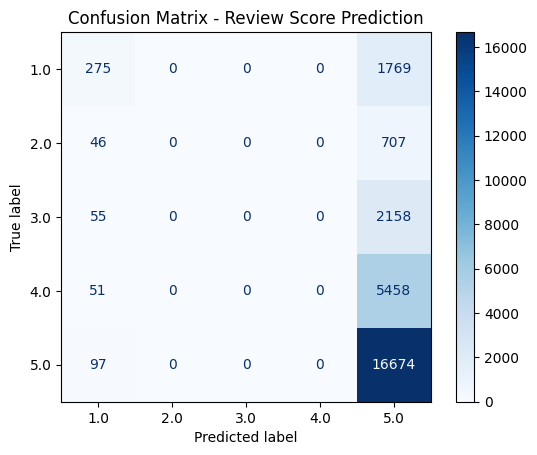


Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.13      0.21      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.00      0.00      0.00      5509
         5.0       0.62      0.99      0.77     16771

    accuracy                           0.62     27290
   macro avg       0.23      0.23      0.20     27290
weighted avg       0.42      0.62      0.49     27290



/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [ ]:
pipeline_review_manual.fit(X_review_train, Y_review_train)

y_pred_review = pipeline_review_manual.predict(X_review_test)

accuracy = accuracy_score(Y_review_test, y_pred_review)
print(f"\nAccuracy on Test Set: {accuracy:.4f}")

cm = confusion_matrix(Y_review_test, y_pred_review)

classes = sorted(Y_review_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Review Score Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_review_test, y_pred_review))

Dentro de la matriz de confusión podemos observar que todas las predicciones son de valores de 0 o de 5, esto nos puede indicar que posiblemente nuestro modelo es demasiado simple. Potencialmente encontramos mejores resultados explorando por medio de un Gridsearch.

### Gridsearch y Cross Validation

Ahora, vamos a realizar un Gridsearch con validación cruzada para explorar la arquitectura óptima de nuestro modelo según el F1_macro.

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


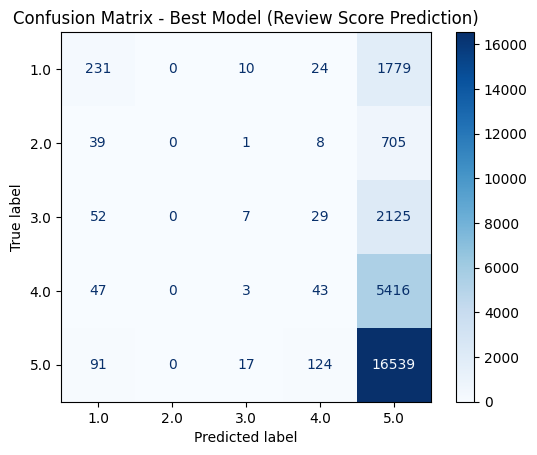


Classification Report (Best Model):
              precision    recall  f1-score   support

         1.0       0.50      0.11      0.18      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.18      0.00      0.01      2213
         4.0       0.19      0.01      0.01      5509
         5.0       0.62      0.99      0.76     16771

    accuracy                           0.62     27290
   macro avg       0.30      0.22      0.19     27290
weighted avg       0.47      0.62      0.49     27290

Best parameters found by Grid Search: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (20, 10, 5), 'model__learning_rate_init': 0.01, 'model__max_iter': 200}


/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [ ]:
param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_review_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_review_train, Y_review_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_review_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_review_test, y_pred_best)
classes = sorted(Y_review_test.unique())
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Review Score Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_review_test, y_pred_best))

print("Best parameters found by Grid Search:", grid_search.best_params_)

Los resultados son bastante similares al inciso anterior, y se comparan a los resultados utilizando modelos de clasificación como Random Forest. El modelo sigue prediciendo bastante seguido los valores más altos, sacrificando la precisión en algunos de los valores intermedios. Además, no parece encontrar una distinción clara entre valores adyacentes. Vale la pena recalcar que en cuánto a arquitectura, el modelo elegido fue más complejo que el inicial. Esto nos sugiere que podríamos explorar arquitecturas aún más complejas

### Conclusiones

- Este clasificador utilizando redes neuronales tuvo resultados similares a las regresiones aplicadas, dónde los valores "macro" son sumamente bajos y los "weighed" tienden a ser más altos.
- En este caso, las ganancias en cuánto a rendimiento del modelo no fueron significativas. Si hubo una mejora, pero los resultados fueron similares.
- Una arquitectura más compleja no necesariamente significa mejores resultados.

## Satisfacción del Cliente

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [ ]:
true_numeric_cols_satisfaction, binary_cols_satisfaction, categorical_cols_satisfaction = get_column_types(X_satisfaction_train)

preprocessing_steps_satisfaction = []

if true_numeric_cols_satisfaction:
    preprocessing_steps_satisfaction.append(('standard_scaler', StandardScaler(), true_numeric_cols_satisfaction))

preprocessor_satisfaction = ColumnTransformer(
    preprocessing_steps_satisfaction,
    remainder='passthrough'
)

model_satisfaction = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_satisfaction_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_satisfaction),
    ('model', model_satisfaction)
])

print(pipeline_satisfaction_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'delivery_days',
                                                   'delivery_delta',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   

### Predicciones

Ahora podemos empezar a hacer predicciones con un modelo básico

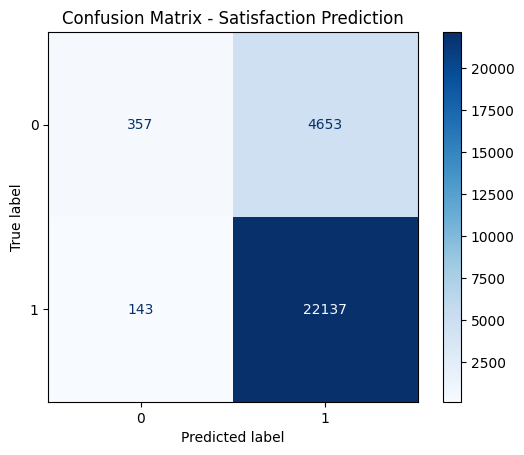


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.07      0.13      5010
           1       0.83      0.99      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.77      0.53      0.52     27290
weighted avg       0.81      0.82      0.76     27290



In [ ]:
pipeline_satisfaction_manual.fit(X_satisfaction_train, Y_satisfaction_train)

y_pred_satisfaction = pipeline_satisfaction_manual.predict(X_satisfaction_test)

cm_satisfaction = confusion_matrix(Y_satisfaction_test, y_pred_satisfaction)

classes_satisfaction = sorted(Y_satisfaction_test.unique())

disp_satisfaction = ConfusionMatrixDisplay(confusion_matrix=cm_satisfaction, display_labels=classes_satisfaction)
disp_satisfaction.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Satisfaction Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_satisfaction_test, y_pred_satisfaction))

Esta red neuronal tiene resultados comparables al mejor modelo de clasificación, a pesar de tener una precisión más alta en valores de 1, sigue teniendo una precisión de 0.71 para valores de clientes no satisfcehos.

### Gridsearch y Cross-Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


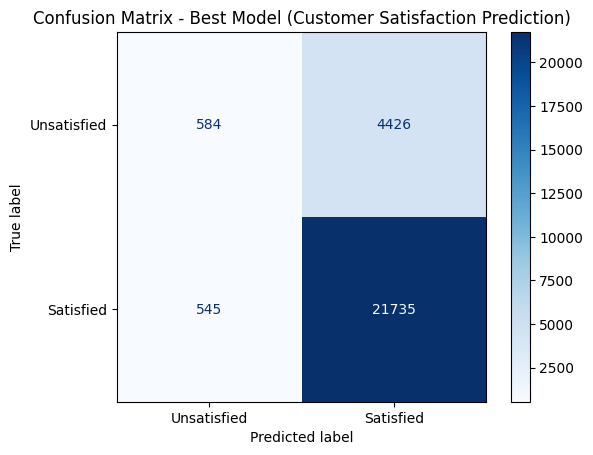


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.52      0.12      0.19      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.67      0.55      0.54     27290
weighted avg       0.77      0.82      0.77     27290

Best parameters found by Grid Search: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (20, 10, 5), 'model__learning_rate_init': 0.001, 'model__max_iter': 500}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_satisfaction_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_satisfaction_train, Y_satisfaction_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_satisfaction_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_satisfaction_test, y_pred_best)
classes = ['Unsatisfied', 'Satisfied']
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Customer Satisfaction Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_satisfaction_test, y_pred_best))
print("Best parameters found by Grid Search:", grid_search.best_params_)


Este modelo en comparación al anterior tiene un recall y un f1 considerablemente mayor para clientes no satisfechos en comparación al anterior. Además, la arquitectura de este modelo es más compleja en comparación al inicial. Esto nos lleva a concluir que un modelo más complejo puede predecir variables menos frecuentes con mayor exactitud, y vale la pena seguir explorando arquitecturas más complejas.

### Conclusiones

- La clasificación utilizando redes neuronales tuvo las mejores métricas en general, superando los demás modelos de clasificación
- Los modelos más complejos pueden adaptarse mejor a distribuciones disparejas
- Utilizar Gridsearch con validación cruzada es una estrategia viable al implementar redes neuronales

## Delivery Delayed

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [ ]:
true_numeric_cols_delayed, binary_cols_delayed, categorical_cols_delayed = get_column_types(X_delayed_train)

preprocessing_steps_delayed = []

if true_numeric_cols_delayed:
    preprocessing_steps_delayed.append(('standard_scaler', StandardScaler(), true_numeric_cols_delayed))

preprocessor_delayed = ColumnTransformer(
    preprocessing_steps_delayed,
    remainder='passthrough'
)

model_delayed = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_delayed_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_delayed),
    ('model', model_delayed)
])

print(pipeline_delayed_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   'product_size_factor'])])),
                ('model',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 3),
      

### Predicciones


Accuracy on Test Set: 0.9632


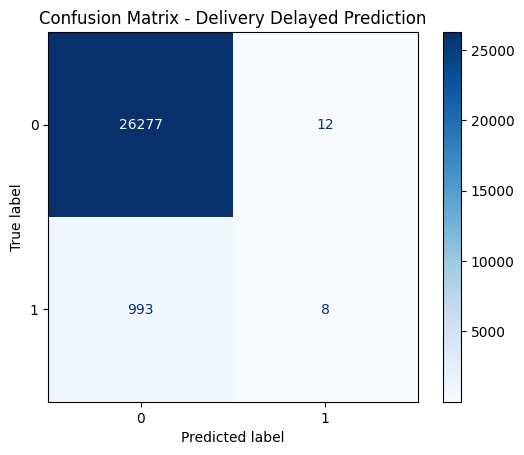


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.40      0.01      0.02      1001

    accuracy                           0.96     27290
   macro avg       0.68      0.50      0.50     27290
weighted avg       0.94      0.96      0.95     27290



In [ ]:
pipeline_delayed_manual.fit(X_delayed_train, Y_delayed_train)

y_pred_delayed = pipeline_delayed_manual.predict(X_delayed_test)

accuracy_delayed = accuracy_score(Y_delayed_test, y_pred_delayed)
print(f"\nAccuracy on Test Set: {accuracy_delayed:.4f}")

cm_delayed = confusion_matrix(Y_delayed_test, y_pred_delayed)

classes_delayed = sorted(Y_delayed_test.unique())

disp_delayed = ConfusionMatrixDisplay(confusion_matrix=cm_delayed, display_labels=classes_delayed)
disp_delayed.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Delivery Delayed Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_delayed_test, y_pred_delayed))

Este modelo parece tener números bastante prometedores, ya que los promedios weighed son bastante altos. Sin embargo, esto puede no contar toda la historia. Ya que para los pedidos atrasados el recall y el puntaje f1 son sumamente bajos. Este modelo generaliza mucho, y esperamos que, similar al modelo anterior, al explorar diferentes arquitecturas más complejas logremos tener mejores resultados para estos parámetros con menor representación.

### Gridsearch y Cross Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


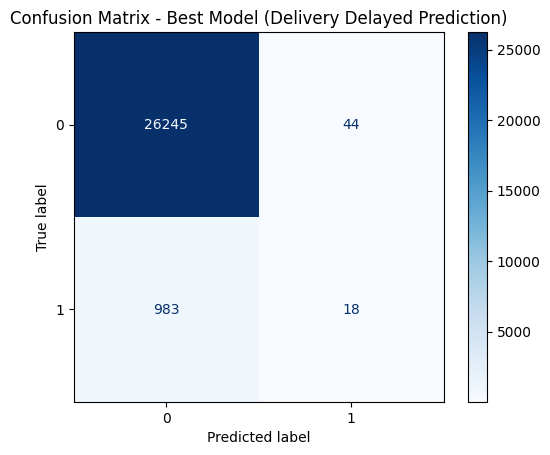


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.29      0.02      0.03      1001

    accuracy                           0.96     27290
   macro avg       0.63      0.51      0.51     27290
weighted avg       0.94      0.96      0.95     27290

Best parameters found by Grid Search: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (10, 5), 'model__learning_rate_init': 0.01, 'model__max_iter': 200}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_delayed_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_delayed_train, Y_delayed_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_delayed_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_delayed_test, y_pred_best)
classes = sorted(Y_delayed_test.unique())
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Delivery Delayed Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_delayed_test, y_pred_best))

print("Best parameters found by Grid Search:", grid_search.best_params_)

Este modelo tuvo ligeras mejoras sobre el anterior, al explorar una arquitectura más compleja y diferentes parámetros utilizando validación cruzada logramos tener mejores predicciones para deliveries atrasados. En este caso, el recall fue mayor para los pedidos atrasados. Sin embargo, los resultados siguen sin ser muy prometedores y siguen estando al mismo nivel que algunos modelos de clasificación.

### Conclusiones

- El modelo presenta dificultades similares a los demás modelos de clasificación, dónde los datos con poca representación son difíciles de predecir
- Se pueden seguir explorando arquitecturas más complejas y parámetros más variados, ya que por limitaciones de cómputo llegamos al límite con altos tiempos de ejecución
- La complejidad del modelo y el tiempo de cómputo no se relacionan directamente, ya que el trabajo fue muy tardado y las ganancias fueron pocas. Se debe de buscar un balance entre estas variables.

# Regresión

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [ ]:
from sklearn.neural_network import MLPRegressor
true_numeric_cols_days, binary_cols_days, categorical_cols_days = get_column_types(X_days_train)

preprocessing_steps_days = []

if true_numeric_cols_days:
    preprocessing_steps_days.append(('standard_scaler', StandardScaler(), true_numeric_cols_days))

preprocessor_days = ColumnTransformer(
    preprocessing_steps_days,
    remainder='passthrough'
)

model_days = MLPRegressor(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_days_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_days),
    ('model', model_days)
])

print(pipeline_days_manual)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   'product_size_factor'])])),
                ('model',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(5, 3),
                              random_state=42))])


### Predicciones

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


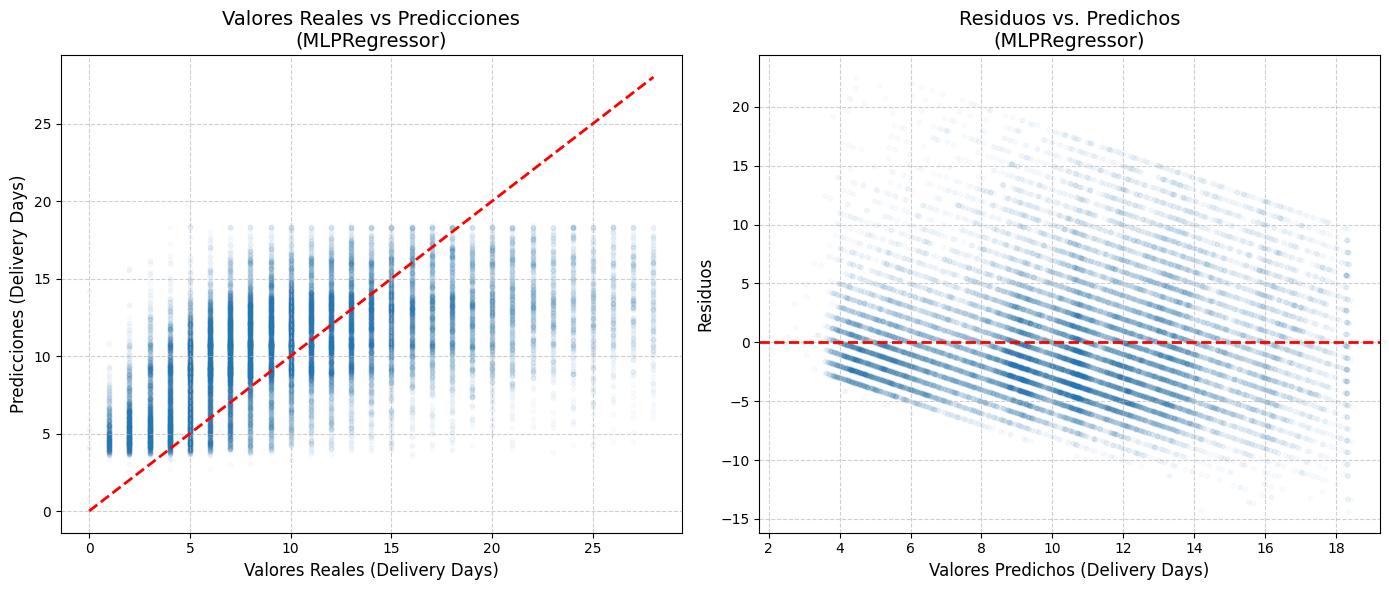


--- Evaluación de MLPRegressor ---
Mean Squared Error (MSE):     25.147722
Root Mean Squared Error (RMSE): 5.014750
Mean Absolute Error (MAE):    3.882067
R-squared (R²):               0.311546
-----------------------------------


In [ ]:
pipeline_days_manual.fit(X_days_train, Y_days_train)
y_pred_days = pipeline_days_manual.predict(X_days_test)

plot_regression_results(Y_days_test, y_pred_days, target_column_name="Delivery Days", model_name="MLPRegressor")

print_regression_metrics(Y_days_test, y_pred_days, model_name="MLPRegressor")

Este modelo tiene resultados prometedores, sus métricas son similares al modelo con mejor desempeño que fue Random Forest. Además, parece captar un trend inicial de manera correcta pero predecir de manera incorrecta valores menos frecuentes. En incisos anteriores, habíamos encontrado una mejora en este aspecto al optar por una arquitectura más compleja e implementar validación cruzada. Adicionalmente, según la gráfica de residuos, parece captar las tendencias generales bastante bien. Teniendo los sectores más concentrados cercanos a la línea de 0. Sin embargo, todavía existen secciones más transparentes dónde se pueden observar las imperfecciones del modelo.

### Gridsearch y Cross Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M

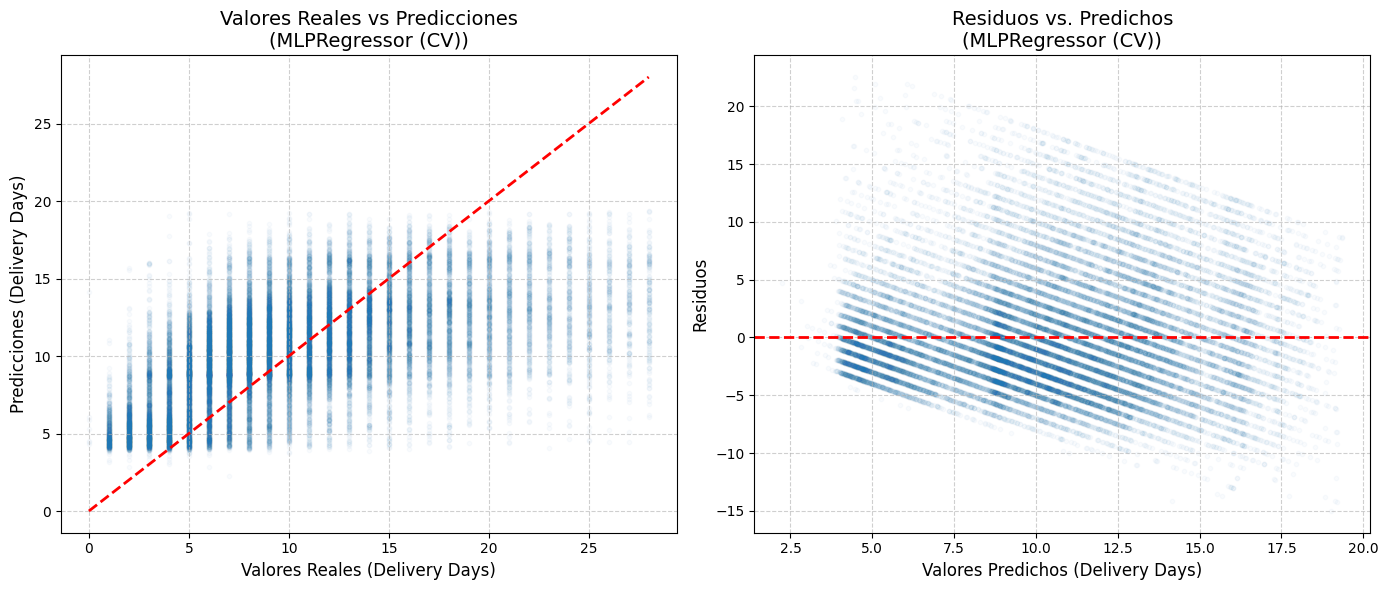


--- Evaluación de MLPRegressor (CV) ---
Mean Squared Error (MSE):     25.107008
Root Mean Squared Error (RMSE): 5.010689
Mean Absolute Error (MAE):    3.854128
R-squared (R²):               0.312661
----------------------------------------

Best parameters found by GridSearchCV for Delivery Days:
{'model__alpha': 0.01, 'model__hidden_layer_sizes': (10, 5), 'model__learning_rate_init': 0.001, 'model__max_iter': 200}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor


param_grid_days = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search_days = GridSearchCV(
    pipeline_days_manual,
    param_grid_days,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

grid_search_days.fit(X_days_train, Y_days_train)

best_pipeline_days = grid_search_days.best_estimator_

y_pred_best_days = best_pipeline_days.predict(X_days_test)

plot_regression_results(Y_days_test, y_pred_best_days, target_column_name="Delivery Days", model_name="MLPRegressor (CV)")

print_regression_metrics(Y_days_test, y_pred_best_days, model_name="MLPRegressor (CV)")

print("\nBest parameters found by GridSearchCV for Delivery Days:")
print(grid_search_days.best_params_)

A pesar de realizar una exploración amplia, dónde se corrió por un tiempo significativo, este modelo obtuvo resultados marginalmente mejores. Sigue compartiendo los mismos problemas, dónde la mayor distinción es que este parece capturar un poco mejor el trend para días mayores a 15.

### Conclusiones

- El modelo de regresión utilizando redes neuronales probó estar a la par de los mejores modelos aplicados.
- Las métricas no son lo único necesario para evaluar modelos, ya que algunos cambios en las gráficas pueden mostrar la diferencia en funcionamiento interno.
- Al variar parámetros, no se puede esperar únicamente hacer modelos más complejos o explorar espacios más amplios. Es necesario entender que hacen estos parámetros y cómo afectan al modelo.

## Conclusiones Finales

- Las redes neuronales tienen altos costos computacionales, por lo que es importante balancear entre mejores métricas y costo.
- La exploración de arquitecturas complejas se vió limitada por los costos computacionales de las mismas.
- Un modelo más complejo no necesariamente significa mejores resultados.
- Los resultados son comparables o superiores a los demás modelos aplicados.
- Gridsearch y validación cruzada probaron ser métodos efectivos para encontrar parámetros adecuados para las redes neuronales.